# <div style="text-align: center;"> **CNN MODELS** </div>

----------------------------

In [1]:
import os
import sys
sys.path.append(os.path.abspath('../scr'))
from import_images import create_image_dataset
from image_loader import LoadImage
from image_preprocesser import preprocess_image, apply_preprocessing
from callbacks_training_CNN import create_reduce_lr_callback, create_early_stopping_callback, train_model
from metrics_CNN import plot_training_history, plot_confusion_matrix, plot_auc_curve
from extract_features import extract_features
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

2024-12-04 08:34:42.679220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733297682.694831 1023539 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733297682.699504 1023539 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 08:34:42.715143: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [42]:
#Directories 
train_dir = "../Data/Processed/ml-dp/train"
val_dir = "../Data/Processed/ml-dp/val"
test_dir = "../Data/Processed/ml-dp/test"

### **Load and Preprocessing images**

In [43]:
#Import images
train_ds = create_image_dataset(train_dir, subset = None, validation_split = None)
val_ds = create_image_dataset(val_dir, subset = None, validation_split = None)
test_ds = create_image_dataset(test_dir, subset = None, validation_split = None)
class_names = train_ds.class_names

Found 3140 files belonging to 2 classes.
Found 615 files belonging to 2 classes.
Found 767 files belonging to 2 classes.


In [44]:
#Preprocessing images
train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255 
)

'''train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    output_size=(256, 256)
)'''

val_ds = apply_preprocessing(
    val_ds,
    rescale=1./255 
)

test_ds = apply_preprocessing(
    test_ds,
    rescale=1./255 
)

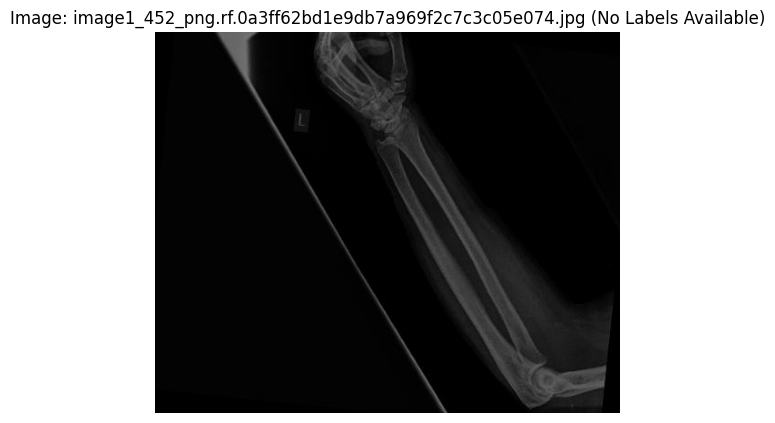

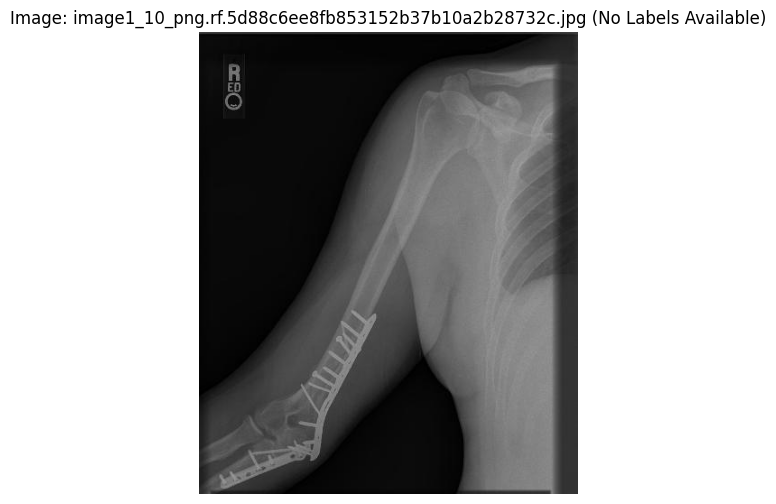

In [17]:
#Plot random images
loader = LoadImage(train_dir)
loader.plot_images_with_bboxes() 


----

### **Contruct a CNN**

### *Model 1*

In [45]:
#Construct the model 
model_CNN1 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN1.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN1.add(layers.Conv2D(32, (3, 3), activation='relu'))
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
model_CNN1.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN1.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN1.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN1.add(layers.Dense(512, activation='relu'))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN1.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN1.add(layers.Dense(1, activation='sigmoid'))

model_CNN1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,079,553 (99.49 MB)

 Trainable params: 26,079,553 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

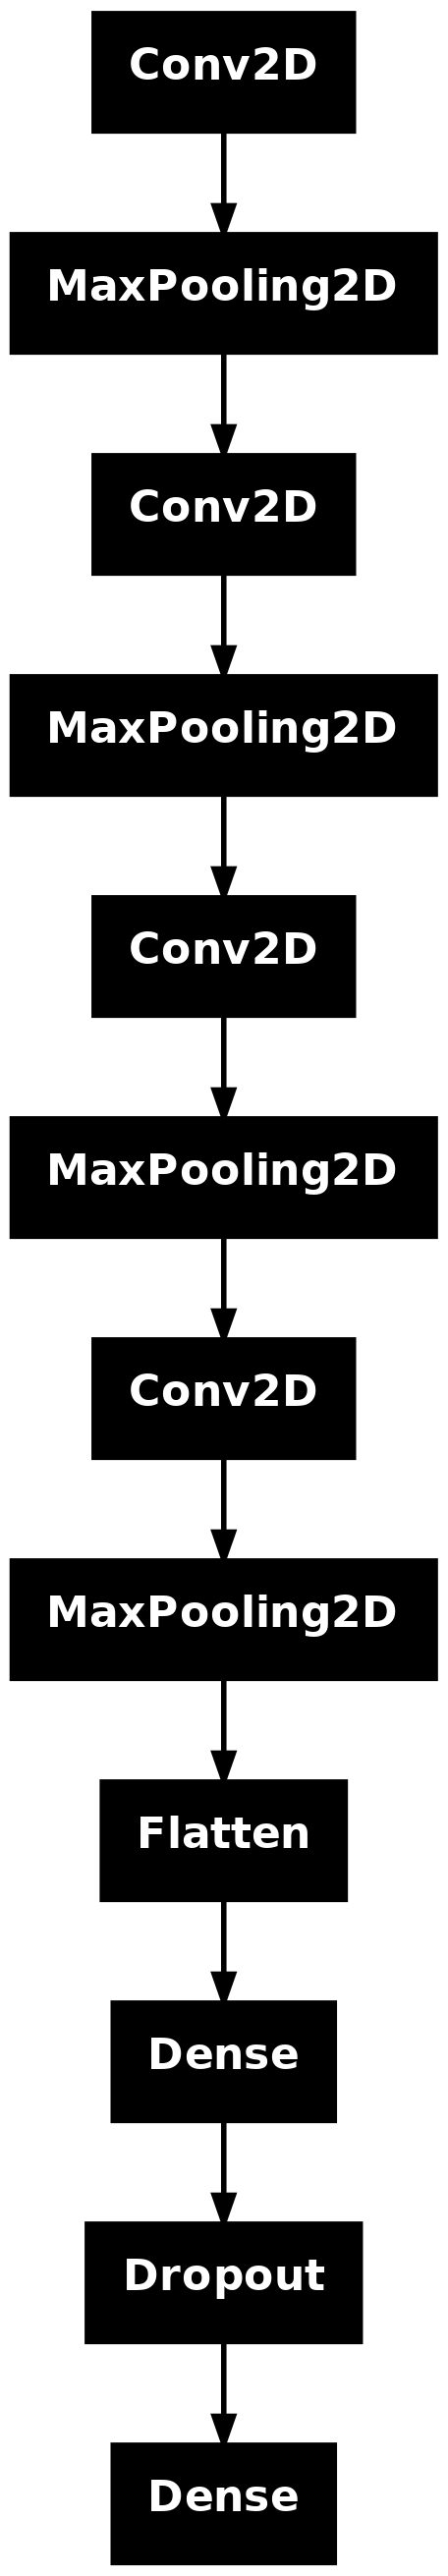

In [6]:
tf.keras.utils.plot_model(model_CNN1)

In [19]:
model_CNN1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #learning rate 0.001

In [20]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback()

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback()

#Train the model 
history = train_model(model_CNN1, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


2024-12-04 10:25:42.602491: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-04 10:25:42.661874: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,32,127,127]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5888 - loss: 0.7736

2024-12-04 10:25:52.964695: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-04 10:25:53.016712: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,32,127,127]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

150/150 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.5888 - loss: 0.7732 - val_accuracy: 0.4959 - val_loss: 0.7060 - learning_rate: 0.0010
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5857 - loss: 0.6833

2024-12-04 10:25:56.291186: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-12-04 10:25:56.291225: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6334 - loss: 0.6691 - val_accuracy: 0.4959 - val_loss: 0.7036 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5917 - loss: 0.6770 - val_accuracy: 0.4959 - val_loss: 0.7823 - learning_rate: 0.0010
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6651 - loss: 0.6752

2024-12-04 10:26:04.102368: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 10:26:04.102406: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6167 - loss: 0.6777 - val_accuracy: 0.4976 - val_loss: 0.6829 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5986 - loss: 0.6692 - val_accuracy: 0.5382 - val_loss: 0.6883 - learning_rate: 0.0010
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5678 - loss: 0.6580

2024-12-04 10:26:11.794525: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 10:26:11.794562: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5713 - loss: 0.6580 - val_accuracy: 0.5301 - val_loss: 0.6823 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5966 - loss: 0.6566 - val_accuracy: 0.5398 - val_loss: 0.7398 - learning_rate: 0.0010
Epoch 8/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7234 - loss: 0.6189

2024-12-04 10:26:19.509628: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 10:26:19.509662: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6943 - loss: 0.6409 - val_accuracy: 0.5236 - val_loss: 0.6955 - learning_rate: 0.0010
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.6176 - loss: 0.6386 - val_accuracy: 0.5837 - val_loss: 0.6806 - learning_rate: 0.0010
Epoch 10/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.6349 - loss: 0.6245

2024-12-04 10:26:27.224246: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 10:26:27.224279: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6563 - loss: 0.6093 - val_accuracy: 0.5398 - val_loss: 0.6993 - learning_rate: 0.0010
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.6437 - loss: 0.6183 - val_accuracy: 0.5902 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 12/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.7074 - loss: 0.5313

2024-12-04 10:26:34.773552: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 10:26:34.773583: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7139 - loss: 0.5436 - val_accuracy: 0.5642 - val_loss: 0.7941 - learning_rate: 0.0010


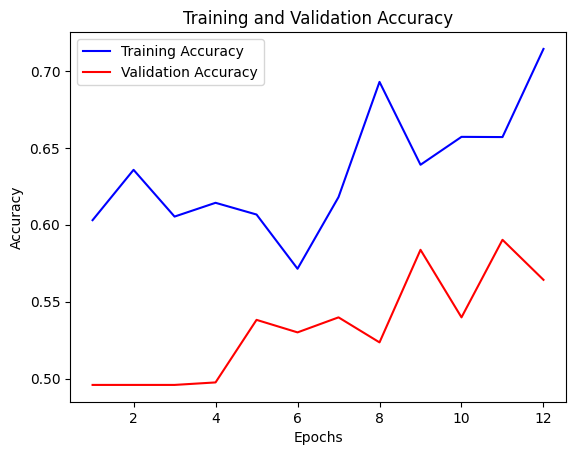

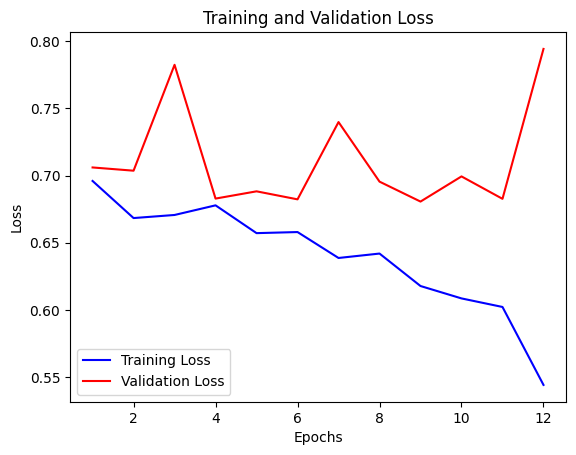

In [21]:
plot_training_history(history)

35/39 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

2024-12-04 10:42:41.631616: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-04 10:42:41.759999: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,64,125,125]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,32,127,127]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
Accuracy on test dataset: 0.4746

Classification Report:
               precision    recall  f1-score   support

    fracture       0.47      0.29      0.36       387
  nofracture       0.48      0.66      0.55       380

    accuracy                           0.47       767
   macro avg       0.47      0.48      0.46       767
weighted avg       0.47      0.47      0.46       767



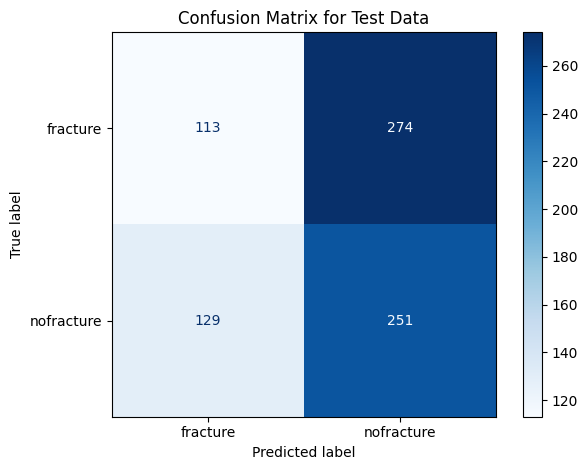

In [27]:
accuracy, class_report, cm = plot_confusion_matrix(model_CNN1, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
AUC: 0.4771


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


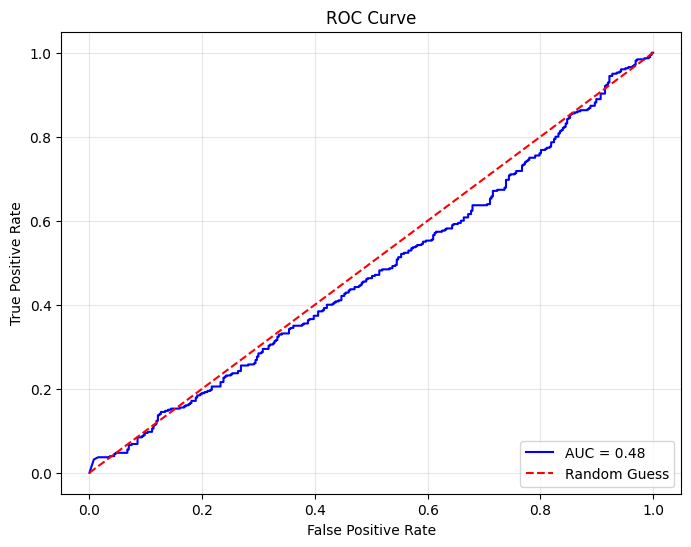

In [28]:
auc = plot_auc_curve(model_CNN1, test_ds)

------

In [29]:
#Same model but patient 10 instead of 3

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 10)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 10)

#Train the model 
history = train_model(model_CNN1, train_ds, epochs = 100, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9055 - loss: 0.2252 - val_accuracy: 0.7675 - val_loss: 0.7970 - learning_rate: 5.0000e-05
Epoch 2/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9237 - loss: 0.2130

2024-12-04 10:47:44.066570: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9421 - loss: 0.1866 - val_accuracy: 0.7626 - val_loss: 0.7829 - learning_rate: 5.0000e-05
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9220 - loss: 0.1930 - val_accuracy: 0.7805 - val_loss: 0.7825 - learning_rate: 5.0000e-05
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9138 - loss: 0.1641 - val_accuracy: 0.7772 - val_loss: 0.7723 - learning_rate: 5.0000e-05
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9346 - loss: 0.1762 - val_accuracy: 0.7756 - val_loss: 0.8717 - learning_rate: 5.0000e-05
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9735 - loss: 0.0996

2024-12-04 10:47:59.700594: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 10:47:59.700626: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9511 - loss: 0.1297 - val_accuracy: 0.7691 - val_loss: 0.8708 - learning_rate: 5.0000e-05
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9329 - loss: 0.1619 - val_accuracy: 0.7642 - val_loss: 0.8923 - learning_rate: 5.0000e-05
Epoch 8/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9518 - loss: 0.1243

2024-12-04 10:48:07.442454: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9297 - loss: 0.1465 - val_accuracy: 0.7756 - val_loss: 0.8510 - learning_rate: 5.0000e-05
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9490 - loss: 0.1399 - val_accuracy: 0.7984 - val_loss: 0.8464 - learning_rate: 5.0000e-05
Epoch 10/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9672 - loss: 0.1017

2024-12-04 10:48:15.098980: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 10:48:15.099015: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9644 - loss: 0.1163 - val_accuracy: 0.7772 - val_loss: 0.8858 - learning_rate: 5.0000e-05
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9509 - loss: 0.1279 - val_accuracy: 0.7870 - val_loss: 0.9114 - learning_rate: 5.0000e-05
Epoch 12/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9564 - loss: 0.1117

2024-12-04 10:48:22.816520: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 10:48:22.816555: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9639 - loss: 0.0974 - val_accuracy: 0.7691 - val_loss: 0.9702 - learning_rate: 5.0000e-05
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9591 - loss: 0.1081 - val_accuracy: 0.7886 - val_loss: 0.9545 - learning_rate: 5.0000e-05
Epoch 14/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9486 - loss: 0.1074

2024-12-04 10:48:30.555702: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 10:48:30.555731: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9499 - loss: 0.1040 - val_accuracy: 0.7707 - val_loss: 1.0149 - learning_rate: 5.0000e-05


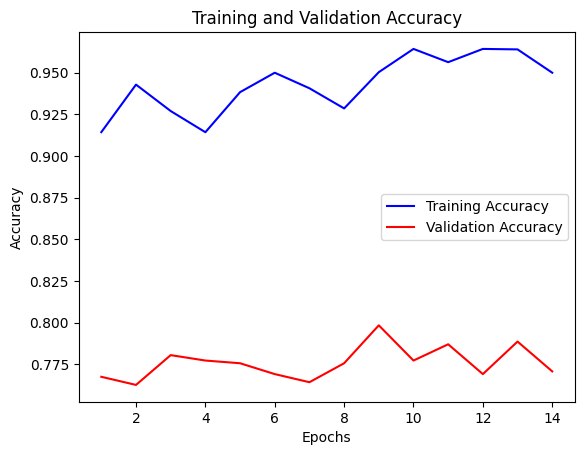

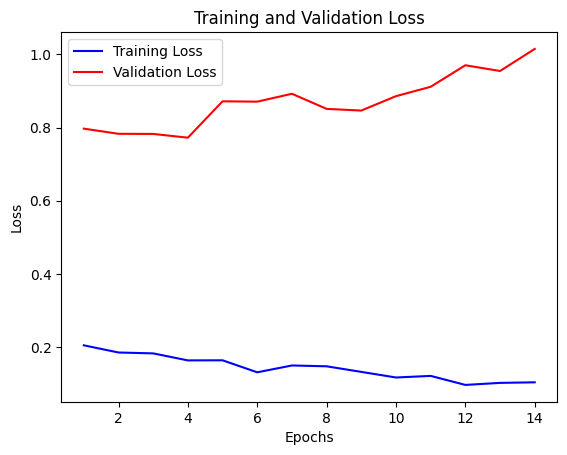

In [30]:
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Accuracy on test dataset: 0.5228

Classification Report:
               precision    recall  f1-score   support

    fracture       0.55      0.33      0.41       387
  nofracture       0.51      0.72      0.60       380

    accuracy                           0.52       767
   macro avg       0.53      0.52      0.50       767
weighted avg       0.53      0.52      0.50       767



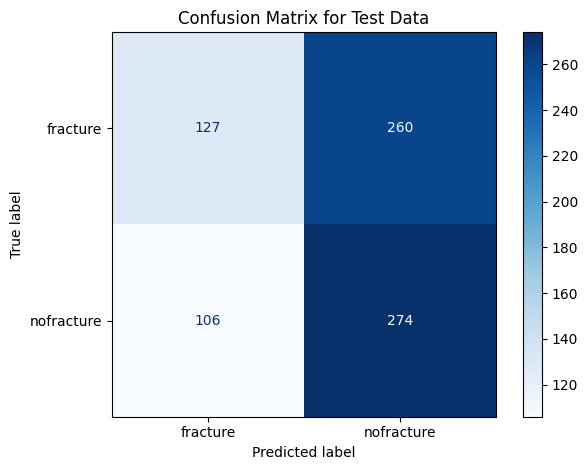

In [31]:
accuracy, class_report, cm = plot_confusion_matrix(model_CNN1, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
AUC: 0.4882


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


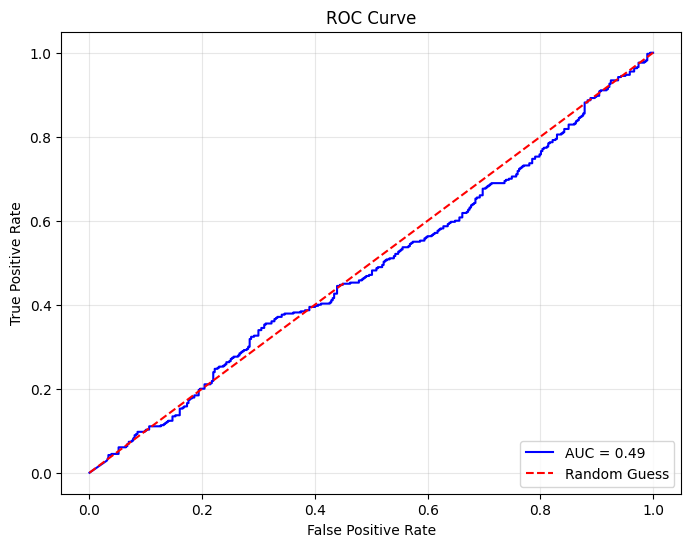

In [33]:
auc = plot_auc_curve(model_CNN1, test_ds)

----

In [24]:
optimizer = Adam(learning_rate=1e-4)
model_CNN1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #learning rate 0.001

In [25]:
#Same model but patient 5

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 5)

#Train the model 
history = train_model(model_CNN1, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.7765 - loss: 0.4485 - val_accuracy: 0.6878 - val_loss: 0.7795 - learning_rate: 1.0000e-04
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8501 - loss: 0.3583 - val_accuracy: 0.6911 - val_loss: 0.7680 - learning_rate: 1.0000e-04
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7971 - loss: 0.4194 - val_accuracy: 0.7041 - val_loss: 0.7553 - learning_rate: 1.0000e-04
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8931 - loss: 0.2733

2024-12-04 10:34:35.987774: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-12-04 10:34:35.987812: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 10:34:35.987823: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8656 - loss: 0.2898 - val_accuracy: 0.7008 - val_loss: 0.7570 - learning_rate: 1.0000e-04
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8330 - loss: 0.3771 - val_accuracy: 0.7154 - val_loss: 0.7378 - learning_rate: 1.0000e-04
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8838 - loss: 0.2305

2024-12-04 10:34:43.890588: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 10:34:43.890619: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8652 - loss: 0.2684 - val_accuracy: 0.7122 - val_loss: 0.7662 - learning_rate: 1.0000e-04
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8494 - loss: 0.3438 - val_accuracy: 0.7252 - val_loss: 0.7213 - learning_rate: 1.0000e-04
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9144 - loss: 0.2423 - val_accuracy: 0.7252 - val_loss: 0.7403 - learning_rate: 1.0000e-04
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8692 - loss: 0.2971 - val_accuracy: 0.7382 - val_loss: 0.7329 - learning_rate: 1.0000e-04
Epoch 10/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9211 - loss: 0.2042

2024-12-04 10:34:59.520960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 10:34:59.520987: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9078 - loss: 0.2206 - val_accuracy: 0.7382 - val_loss: 0.7787 - learning_rate: 1.0000e-04
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8917 - loss: 0.2541 - val_accuracy: 0.7724 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 12/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9286 - loss: 0.1986

2024-12-04 10:35:07.196812: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 10:35:07.196852: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9354 - loss: 0.1730 - val_accuracy: 0.7593 - val_loss: 0.7174 - learning_rate: 1.0000e-04
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9089 - loss: 0.2167 - val_accuracy: 0.7675 - val_loss: 0.8004 - learning_rate: 1.0000e-04
Epoch 14/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9357 - loss: 0.1428 - val_accuracy: 0.7772 - val_loss: 0.7827 - learning_rate: 1.0000e-04
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9262 - loss: 0.1788 - val_accuracy: 0.7951 - val_loss: 0.7472 - learning_rate: 1.0000e-04
Epoch 16/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9411 - loss: 0.1539

2024-12-04 10:35:22.704698: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 10:35:22.704733: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9496 - loss: 0.1308 - val_accuracy: 0.7691 - val_loss: 0.8779 - learning_rate: 1.0000e-04


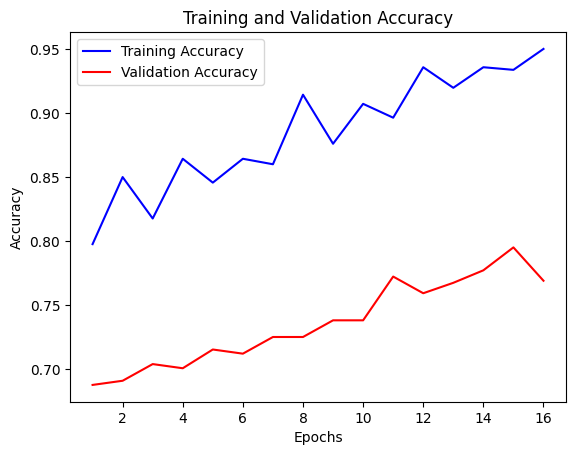

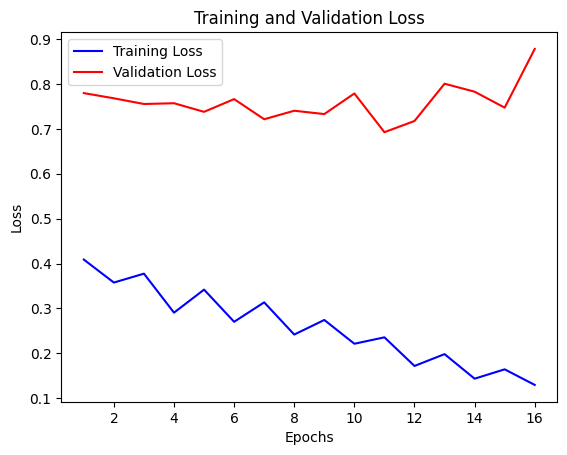

In [26]:
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Accuracy on test dataset: 0.4993

Classification Report:
               precision    recall  f1-score   support

    fracture       0.51      0.30      0.38       387
  nofracture       0.50      0.70      0.58       380

    accuracy                           0.50       767
   macro avg       0.50      0.50      0.48       767
weighted avg       0.50      0.50      0.48       767



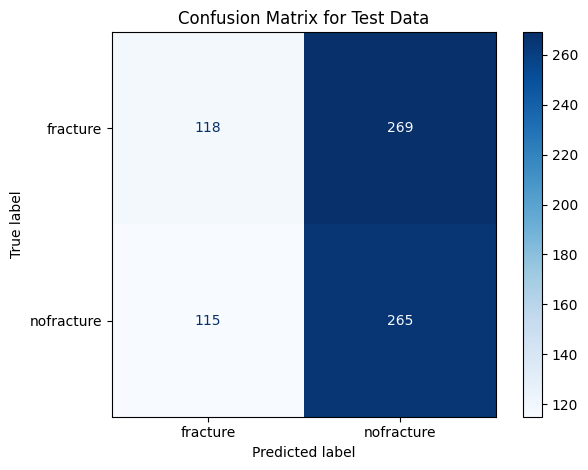

In [34]:
accuracy, class_report, cm = plot_confusion_matrix(model_CNN1, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
AUC: 0.5002


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


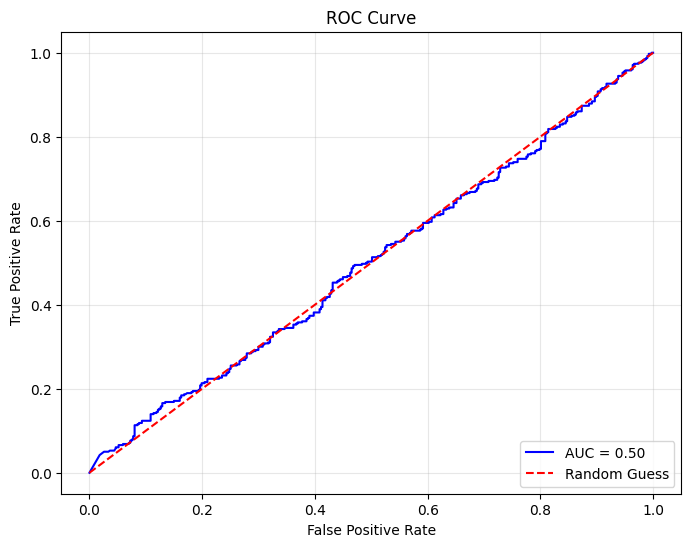

In [35]:
auc = plot_auc_curve(model_CNN1, test_ds)

------------

### *Model 2*

In [46]:
#Construct the model 
model_CNN2 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN2.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN2.add(layers.Conv2D(32, (3, 3), activation='relu'))
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.BatchNormalization()) #this normalizes the last layer activations, stablishing and accelerating the process
model_CNN2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Dropout(0.3)) #add a dropout
model_CNN2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
model_CNN2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_CNN2.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN2.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN2.add(layers.Dense(512, activation='relu'))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN2.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN2.add(layers.Dense(1, activation='sigmoid'))

model_CNN2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,698,241 (21.74 MB)

 Trainable params: 5,698,177 (21.74 MB)

 Non-trainable params: 64 (256.00 B)

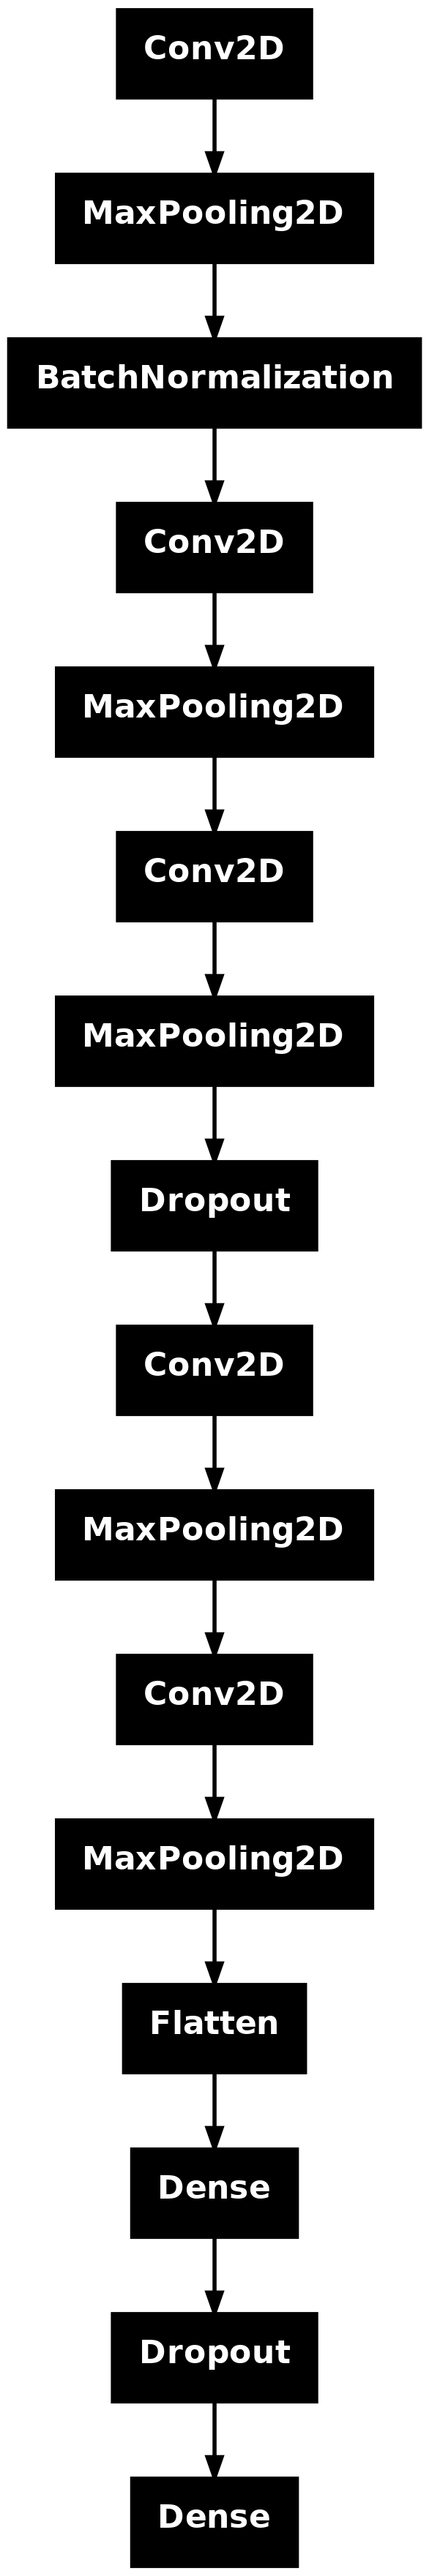

In [35]:
tf.keras.utils.plot_model(model_CNN2)

In [47]:
optimizer = Adam(learning_rate=1e-3)
model_CNN2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
#Same model but patient 5

#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 5)

#Train the model 
history = train_model(model_CNN2, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.5842 - loss: 0.9046 - val_accuracy: 0.4959 - val_loss: 0.6943 - learning_rate: 0.0010
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5857 - loss: 0.6879

2024-12-04 12:13:53.056033: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-12-04 12:13:53.056081: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6334 - loss: 0.6817 - val_accuracy: 0.4959 - val_loss: 0.6951 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5926 - loss: 0.6792 - val_accuracy: 0.4959 - val_loss: 0.7006 - learning_rate: 0.0010
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6651 - loss: 0.6396

2024-12-04 12:14:00.716567: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:14:00.716598: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6167 - loss: 0.6616 - val_accuracy: 0.4959 - val_loss: 0.7004 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5979 - loss: 0.6713 - val_accuracy: 0.4959 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6023 - loss: 0.6766

2024-12-04 12:14:08.424775: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:14:08.424810: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6001 - loss: 0.6776 - val_accuracy: 0.4959 - val_loss: 0.6945 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.5908 - loss: 0.6796 - val_accuracy: 0.4976 - val_loss: 0.6890 - learning_rate: 0.0010
Epoch 8/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6791 - loss: 0.6199

2024-12-04 12:14:17.593471: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:14:17.593505: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6377 - loss: 0.6438 - val_accuracy: 0.4959 - val_loss: 0.7047 - learning_rate: 0.0010
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5927 - loss: 0.6939 - val_accuracy: 0.4959 - val_loss: 0.7187 - learning_rate: 0.0010
Epoch 10/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6568 - loss: 0.6343

2024-12-04 12:14:25.276257: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:14:25.276294: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6366 - loss: 0.6445 - val_accuracy: 0.4959 - val_loss: 0.7647 - learning_rate: 0.0010
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.6008 - loss: 0.6735 - val_accuracy: 0.4959 - val_loss: 0.7126 - learning_rate: 0.0010
Epoch 12/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5149 - loss: 0.7101

2024-12-04 12:14:32.880900: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:14:32.880938: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6233 - loss: 0.6697 - val_accuracy: 0.4959 - val_loss: 0.7081 - learning_rate: 0.0010


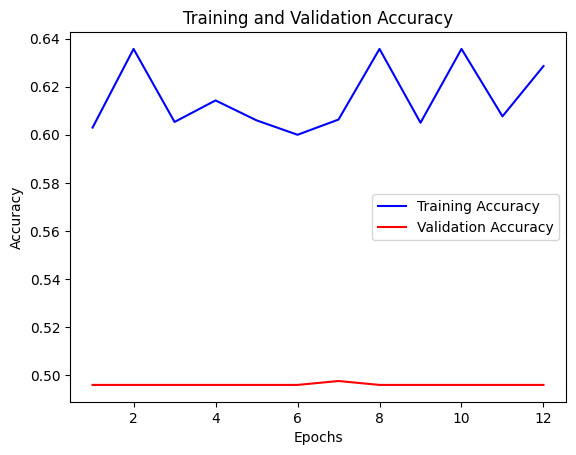

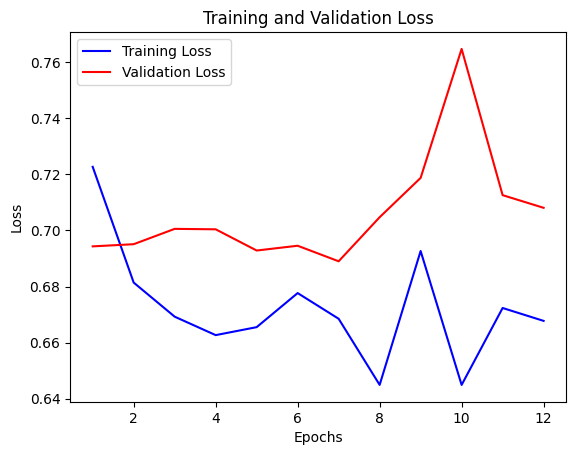

In [49]:
plot_training_history(history)

---------

### *Model 3*

In [51]:
#Construct the model 
model_CNN3 = models.Sequential()
#First layer with teh image format (resolution and channels)
model_CNN3.add(layers.Input(shape=(256, 256, 3))) 
#Convolution layer with 32 kernels 3x3, activation function relu
model_CNN3.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))) #L2 regularization
#Reducing dimesionality wits a MaxPooling 2x2
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.BatchNormalization()) #this normalizes the last layer activations, stablishing and accelerating the process
model_CNN3.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Dropout(0.4)) #add a dropout
model_CNN3.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
model_CNN3.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_CNN3.add(layers.MaxPooling2D((2, 2)))
#Convert the characteristics to an unidemintional vector before construct the Dense layer
model_CNN3.add(layers.Flatten())
#Desnse layer or fully connected layer with 512 neurons
model_CNN3.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#To prevent overfitting, 50% of neurons will be out randomly during train
model_CNN3.add(layers.Dropout(0.5))
#Las layer with 1 node (binary classification and a sigmoid activation)
model_CNN3.add(layers.Dense(1, activation='sigmoid'))

model_CNN3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 127, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,698,241 (21.74 MB)

 Trainable params: 5,698,177 (21.74 MB)

 Non-trainable params: 64 (256.00 B)

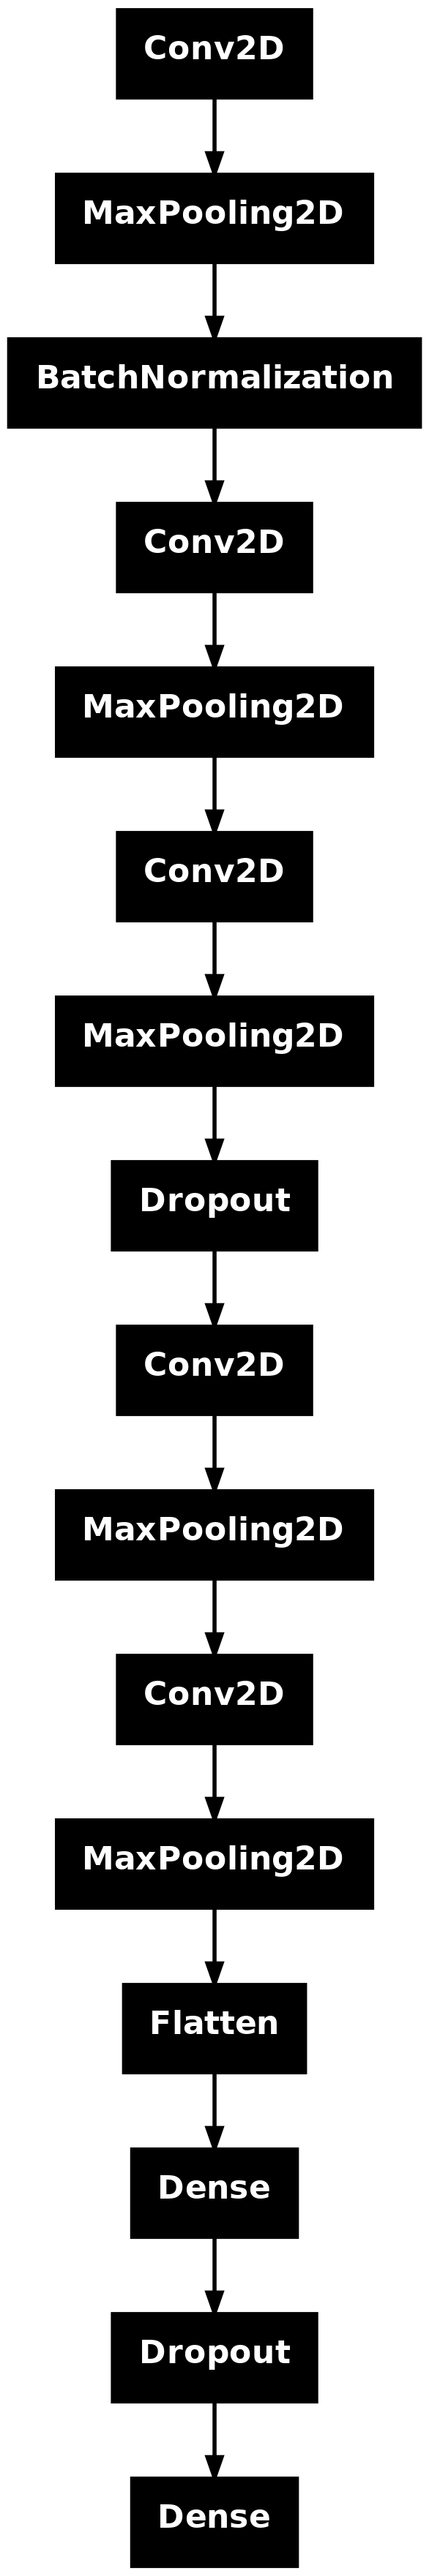

In [40]:
tf.keras.utils.plot_model(model_CNN3)

In [52]:
optimizer = Adam(learning_rate=1e-3)
model_CNN3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 5)

#Train the model 
history = train_model(model_CNN3, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.5743 - loss: 6.4122 - val_accuracy: 0.4959 - val_loss: 1.0030 - learning_rate: 0.0010
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.5750 - loss: 0.9709

2024-12-04 12:15:26.536305: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-12-04 12:15:26.536345: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6125 - loss: 0.9543 - val_accuracy: 0.4959 - val_loss: 0.9811 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5939 - loss: 0.8656 - val_accuracy: 0.4959 - val_loss: 0.7739 - learning_rate: 0.0010
Epoch 4/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6013 - loss: 0.7359

2024-12-04 12:15:34.315289: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6273 - loss: 0.7286 - val_accuracy: 0.4959 - val_loss: 0.7767 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5898 - loss: 0.7289 - val_accuracy: 0.4959 - val_loss: 0.7428 - learning_rate: 0.0010
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6448 - loss: 0.6817 - val_accuracy: 0.4959 - val_loss: 0.7495 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5945 - loss: 0.6979 - val_accuracy: 0.4959 - val_loss: 0.7279 - learning_rate: 0.0010
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5685 - loss: 0.6982 - val_accuracy: 0.4959 - val_loss: 0.7306 - learning_rate: 0.0010
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.5931 - loss: 0.6862 - val_accuracy: 0.4959 - val_loss: 0.7207 - learning_rate: 0.0010
Epoch 10/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6373 - loss: 0.6634 - v

2024-12-04 12:16:06.323699: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6067 - loss: 0.6727 - val_accuracy: 0.4959 - val_loss: 0.7196 - learning_rate: 0.0010
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5958 - loss: 0.6777 - val_accuracy: 0.4959 - val_loss: 0.7157 - learning_rate: 0.0010
Epoch 14/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6852 - loss: 0.6439

2024-12-04 12:16:14.010064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:16:14.010107: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6516 - loss: 0.6569 - val_accuracy: 0.4959 - val_loss: 0.7188 - learning_rate: 0.0010
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.5926 - loss: 0.6789 - val_accuracy: 0.4959 - val_loss: 0.7166 - learning_rate: 0.0010
Epoch 16/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6080 - loss: 0.6747

2024-12-04 12:16:21.628450: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6344 - loss: 0.6630 - val_accuracy: 0.4959 - val_loss: 0.7178 - learning_rate: 0.0010
Epoch 17/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5891 - loss: 0.6795 - val_accuracy: 0.4959 - val_loss: 0.7183 - learning_rate: 0.0010
Epoch 18/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.5913 - loss: 0.6759

2024-12-04 12:16:29.305029: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6064 - loss: 0.6691 - val_accuracy: 0.4959 - val_loss: 0.7181 - learning_rate: 0.0010


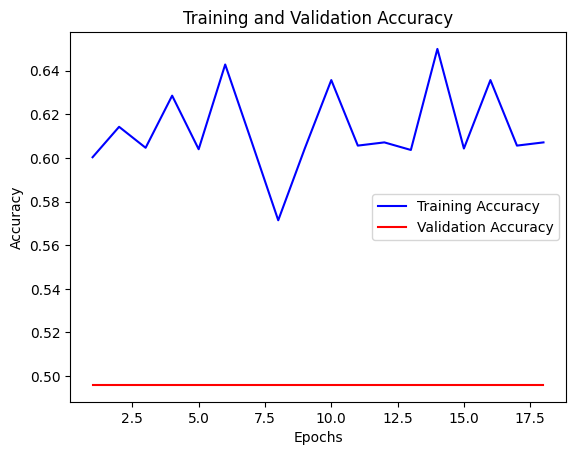

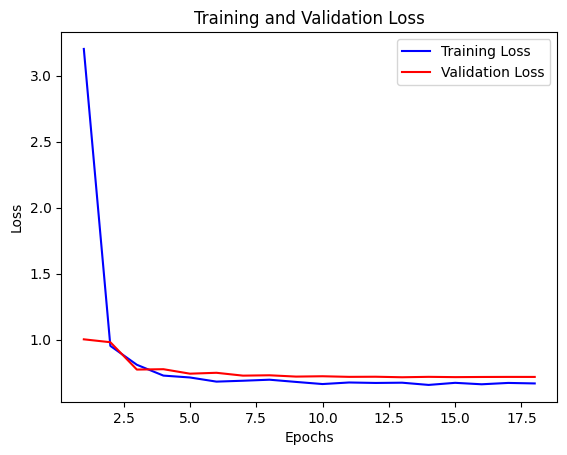

In [54]:
plot_training_history(history)

------------

### **Pretrained network VGG16**

In [55]:
conv_base_VGG16 = VGG16(weights='imagenet', #Charging the pre-trined weights of VGG16 models with  ImageNet dataset
                  include_top=False, #This option indicates that the last layers (fully connected layers) used for final classification don't be imported
                  input_shape=(224, 224, 3)) #This CNN is optimized with a 224x224 resolution

conv_base_VGG16.trainable = False #freezing layers

conv_base_VGG16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

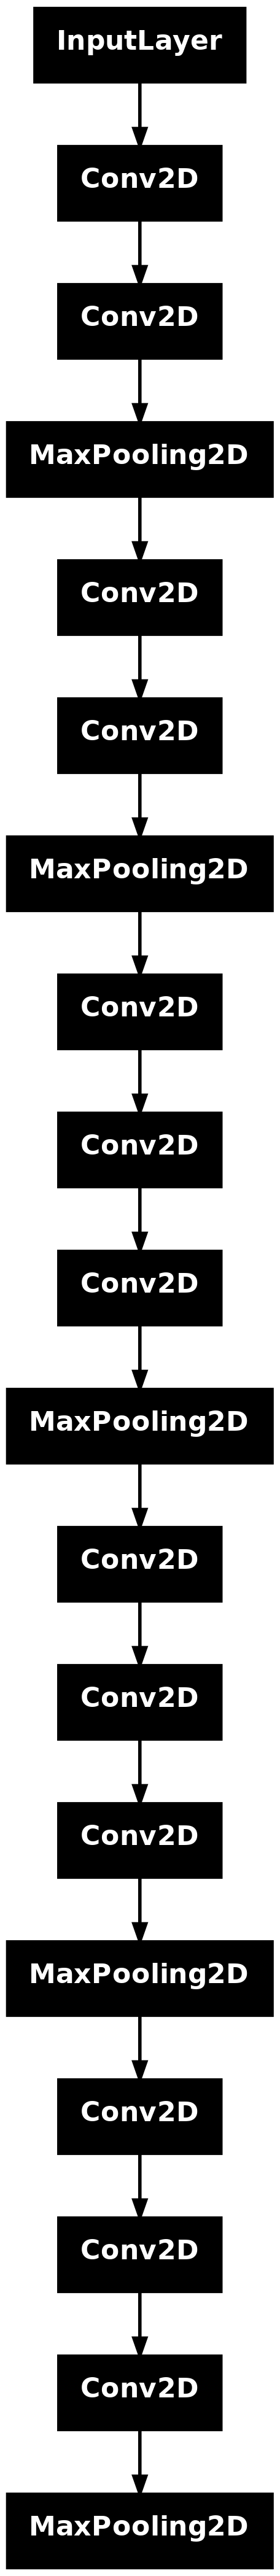

In [19]:
tf.keras.utils.plot_model(conv_base_VGG16)

### *Loading and preprocessing images*

In [56]:
train_ds = create_image_dataset(train_dir, subset = None, validation_split = None, image_size = (224, 224))
val_ds = create_image_dataset(val_dir, subset = None, validation_split = None, image_size = (224, 224))
test_ds = create_image_dataset(test_dir, subset = None, validation_split = None, image_size = (224, 224))
class_names = train_ds.class_names

Found 3140 files belonging to 2 classes.
Found 615 files belonging to 2 classes.
Found 767 files belonging to 2 classes.


In [57]:
#Preprocessing images
train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255 
)
'''train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    output_size=(224, 224)
)'''

val_ds = apply_preprocessing(
    val_ds,
    rescale=1./255 
)

test_ds = apply_preprocessing(
    test_ds,
    rescale=1./255 
)

### *Fine-tunning*

**Model 1**

In [58]:
model_VGG16_1 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_VGG16_1.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_1.add(layers.Flatten())  # Flatten extracted features
model_VGG16_1.add(layers.Dense(256, activation='relu'))  # Full-connected layer
model_VGG16_1.add(layers.Dropout(0.5))  #To avoid over-fitting
model_VGG16_1.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

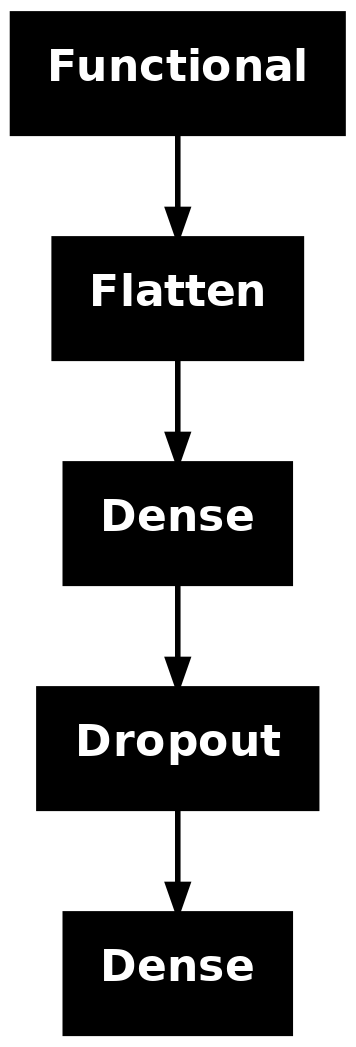

In [6]:
tf.keras.utils.plot_model(model_VGG16_1)

In [59]:
model_VGG16_1.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 10)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 10)

#Train the model 
history = train_model(model_VGG16_1, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


2024-12-04 12:17:52.324014: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-04 12:17:52.450188: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5538 - loss: 1.2006

2024-12-04 12:18:20.784004: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-04 12:18:20.851244: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasAct

150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 191ms/step - accuracy: 0.5540 - loss: 1.1985 - val_accuracy: 0.5789 - val_loss: 0.6632 - learning_rate: 0.0010
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.5792 - loss: 0.6429

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6263 - loss: 0.6312 - val_accuracy: 0.5203 - val_loss: 0.6958 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.6149 - loss: 0.6551 - val_accuracy: 0.5577 - val_loss: 0.6565 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6453 - loss: 0.6006 - val_accuracy: 0.5756 - val_loss: 0.6522 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - accuracy: 0.6393 - loss: 0.6241 - val_accuracy: 0.6732 - val_loss: 0.6323 - learning_rate: 0.0010
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.6755 - loss: 0.6209

2024-12-04 12:19:21.272038: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6648 - loss: 0.6079 - val_accuracy: 0.6829 - val_loss: 0.6186 - learning_rate: 0.0010
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 144ms/step - accuracy: 0.6567 - loss: 0.5989 - val_accuracy: 0.6829 - val_loss: 0.6157 - learning_rate: 0.0010
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6647 - loss: 0.6012 - val_accuracy: 0.5967 - val_loss: 0.6417 - learning_rate: 0.0010
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 147ms/step - accuracy: 0.6557 - loss: 0.6014 - val_accuracy: 0.7122 - val_loss: 0.5792 - learning_rate: 0.0010
Epoch 10/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.6353 - loss: 0.6135

2024-12-04 12:20:15.526833: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:20:15.526933: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6692 - loss: 0.5878 - val_accuracy: 0.6813 - val_loss: 0.6060 - learning_rate: 0.0010
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.6731 - loss: 0.5531 - val_accuracy: 0.7203 - val_loss: 0.5542 - learning_rate: 0.0010
Epoch 12/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7128 - loss: 0.5252 - val_accuracy: 0.6341 - val_loss: 0.6132 - learning_rate: 0.0010
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.6398 - loss: 0.5707 - val_accuracy: 0.7398 - val_loss: 0.5503 - learning_rate: 0.0010
Epoch 14/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.6730 - loss: 0.5562

2024-12-04 12:21:08.176593: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:21:08.176624: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6919 - loss: 0.5477 - val_accuracy: 0.7366 - val_loss: 0.5371 - learning_rate: 0.0010
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.6800 - loss: 0.5439 - val_accuracy: 0.7220 - val_loss: 0.5766 - learning_rate: 0.0010
Epoch 16/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.6197 - loss: 0.6643

2024-12-04 12:21:34.485509: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:21:34.485544: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6350 - loss: 0.6118 - val_accuracy: 0.6439 - val_loss: 0.5989 - learning_rate: 0.0010
Epoch 17/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.6818 - loss: 0.5292 - val_accuracy: 0.7610 - val_loss: 0.5224 - learning_rate: 0.0010
Epoch 18/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.6696 - loss: 0.5334

2024-12-04 12:22:00.963058: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:22:00.963090: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6441 - loss: 0.5398 - val_accuracy: 0.6764 - val_loss: 0.6050 - learning_rate: 0.0010
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.6889 - loss: 0.5097 - val_accuracy: 0.7577 - val_loss: 0.5190 - learning_rate: 0.0010
Epoch 20/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7049 - loss: 0.4750 - val_accuracy: 0.7187 - val_loss: 0.5355 - learning_rate: 0.0010
Epoch 21/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.6915 - loss: 0.5227 - val_accuracy: 0.7447 - val_loss: 0.4966 - learning_rate: 0.0010
Epoch 22/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6990 - loss: 0.5506 - val_accuracy: 0.6309 - val_loss: 0.6439 - learning_rate: 0.0010
Epoch 23/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - accuracy: 0.7049 - loss: 0.4958 - val_accuracy: 0.7024 - val_loss: 0.5770 - learning_rate: 0.0010
Epoch 24/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7237 - l

2024-12-04 12:24:00.823604: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:24:00.823635: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7789 - loss: 0.4875 - val_accuracy: 0.7984 - val_loss: 0.5082 - learning_rate: 0.0010
Epoch 27/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.7240 - loss: 0.4909 - val_accuracy: 0.7171 - val_loss: 0.5385 - learning_rate: 0.0010
Epoch 28/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7765 - loss: 0.3966 - val_accuracy: 0.7431 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 29/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.7175 - loss: 0.4632 - val_accuracy: 0.7919 - val_loss: 0.4726 - learning_rate: 0.0010
Epoch 30/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 0.7082 - loss: 0.4282

2024-12-04 12:24:53.300573: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:24:53.300605: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7480 - loss: 0.4230 - val_accuracy: 0.7886 - val_loss: 0.4884 - learning_rate: 0.0010
Epoch 31/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7369 - loss: 0.4312 - val_accuracy: 0.8179 - val_loss: 0.4418 - learning_rate: 0.0010
Epoch 32/100
  5/150 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.7752 - loss: 0.3509

2024-12-04 12:25:19.692048: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:25:19.692080: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7578 - loss: 0.3680 - val_accuracy: 0.7919 - val_loss: 0.4831 - learning_rate: 0.0010
Epoch 33/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.7405 - loss: 0.4142 - val_accuracy: 0.7398 - val_loss: 0.5416 - learning_rate: 0.0010
Epoch 34/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.8025 - loss: 0.3433

2024-12-04 12:25:45.972155: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:25:45.972183: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8001 - loss: 0.3984 - val_accuracy: 0.7837 - val_loss: 0.4208 - learning_rate: 0.0010
Epoch 35/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.7637 - loss: 0.4173 - val_accuracy: 0.7675 - val_loss: 0.5512 - learning_rate: 0.0010
Epoch 36/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6823 - loss: 0.4242 - val_accuracy: 0.8081 - val_loss: 0.4309 - learning_rate: 0.0010
Epoch 37/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7715 - loss: 0.4180 - val_accuracy: 0.7935 - val_loss: 0.4640 - learning_rate: 0.0010
Epoch 38/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7225 - loss: 0.4276 - val_accuracy: 0.7854 - val_loss: 0.4711 - learning_rate: 0.0010
Epoch 39/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.7760 - loss: 0.3996 - val_accuracy: 0.7528 - val_loss: 0.5524 - learning_rate: 0.0010
Epoch 40/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.8316 -

2024-12-04 12:27:05.332338: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7947 - loss: 0.3724 - val_accuracy: 0.7398 - val_loss: 0.5521 - learning_rate: 0.0010
Epoch 41/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7695 - loss: 0.4053 - val_accuracy: 0.8309 - val_loss: 0.4446 - learning_rate: 0.0010
Epoch 42/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.8571 - loss: 0.2810

2024-12-04 12:27:31.739406: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:27:31.739488: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7890 - loss: 0.3520 - val_accuracy: 0.8439 - val_loss: 0.4113 - learning_rate: 0.0010
Epoch 43/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.8018 - loss: 0.3641 - val_accuracy: 0.8049 - val_loss: 0.4814 - learning_rate: 0.0010
Epoch 44/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7349 - loss: 0.4233 - val_accuracy: 0.8244 - val_loss: 0.3736 - learning_rate: 0.0010
Epoch 45/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 145ms/step - accuracy: 0.7597 - loss: 0.3989 - val_accuracy: 0.7967 - val_loss: 0.4480 - learning_rate: 0.0010
Epoch 46/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - accuracy: 0.6182 - loss: 0.4455

2024-12-04 12:28:24.435911: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:28:24.435940: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.6213 - loss: 0.4464 - val_accuracy: 0.8537 - val_loss: 0.3608 - learning_rate: 0.0010
Epoch 47/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7381 - loss: 0.4028 - val_accuracy: 0.8244 - val_loss: 0.4479 - learning_rate: 0.0010
Epoch 48/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.7549 - loss: 0.3409

2024-12-04 12:28:50.933336: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:28:50.933380: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7775 - loss: 0.3228 - val_accuracy: 0.8016 - val_loss: 0.4702 - learning_rate: 0.0010
Epoch 49/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7631 - loss: 0.3795 - val_accuracy: 0.8293 - val_loss: 0.4542 - learning_rate: 0.0010
Epoch 50/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 16s 119ms/step - accuracy: 0.8104 - loss: 0.3181

2024-12-04 12:29:17.420651: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:29:17.420688: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8413 - loss: 0.3129 - val_accuracy: 0.7756 - val_loss: 0.5612 - learning_rate: 0.0010
Epoch 51/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.8089 - loss: 0.3332 - val_accuracy: 0.8130 - val_loss: 0.4716 - learning_rate: 0.0010
Epoch 52/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8155 - loss: 0.3471 - val_accuracy: 0.8504 - val_loss: 0.3860 - learning_rate: 0.0010
Epoch 53/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7780 - loss: 0.3938 - val_accuracy: 0.8407 - val_loss: 0.4218 - learning_rate: 0.0010
Epoch 54/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8147 - loss: 0.3404 - val_accuracy: 0.7675 - val_loss: 0.5543 - learning_rate: 0.0010
Epoch 55/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 146ms/step - accuracy: 0.7870 - loss: 0.3672 - val_accuracy: 0.7350 - val_loss: 0.5704 - learning_rate: 0.0010
Epoch 56/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7369 - l

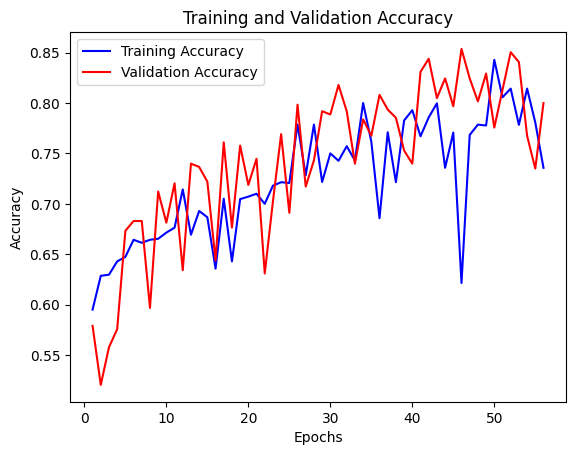

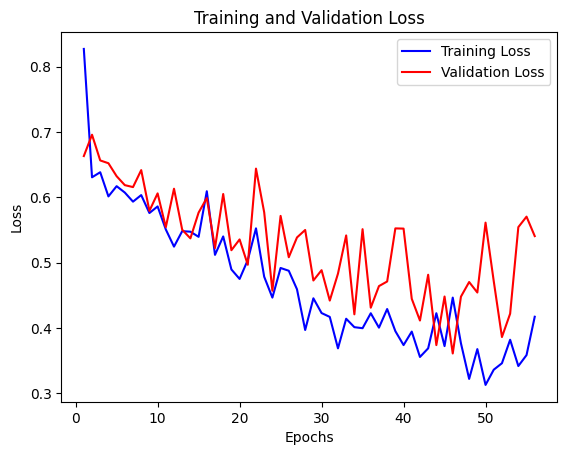

In [61]:
plot_training_history(history)

38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

2024-12-04 12:33:19.917737: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-04 12:33:19.993932: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[7,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step
Accuracy on test dataset: 0.4967

Classification Report:
               precision    recall  f1-score   support

    fracture       0.50      0.44      0.47       387
  nofracture       0.49      0.55      0.52       380

    accuracy                           0.50       767
   macro avg       0.50      0.50      0.50       767
weighted avg       0.50      0.50      0.50       767



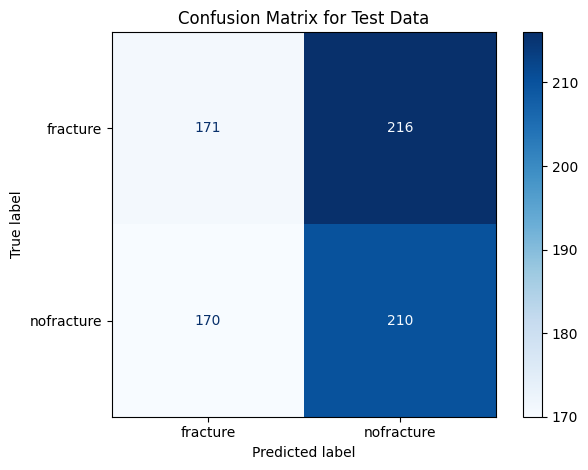

In [62]:
accuracy, class_report, cm = plot_confusion_matrix(model_VGG16_1, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
AUC: 0.4843


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


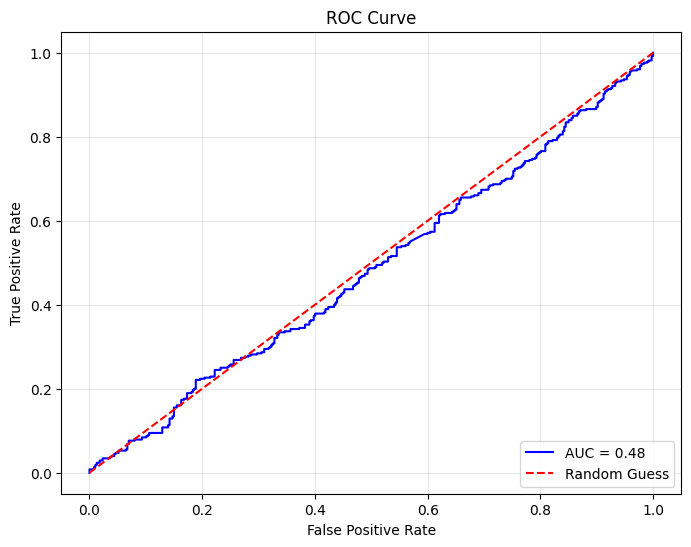

In [63]:
auc = plot_auc_curve(model_VGG16_1, test_ds)

---------------------

**Model 2**

In [64]:
#Unfreezing the lats 8 layers
for layer in conv_base_VGG16.layers[-8:]:
    layer.trainable = True

In [65]:
model_VGG16_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_VGG16_2.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_2.add(layers.Flatten())  # Flatten extracted features
model_VGG16_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_VGG16_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_VGG16_2.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 19,402,241 (74.01 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

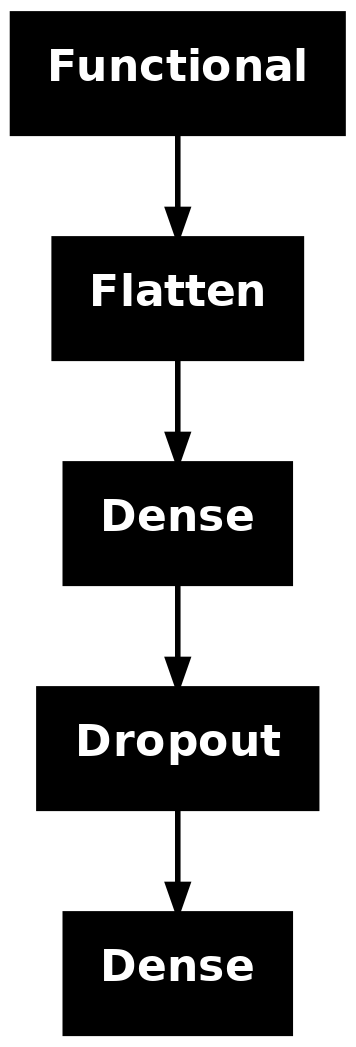

In [26]:
tf.keras.utils.plot_model(model_VGG16_2)

In [66]:
optimizer = Adam(learning_rate=1e-5)
model_VGG16_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_VGG16_2, train_ds, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


2024-12-04 12:34:30.082434: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,256,28,28]{3,2,1,0}, f32[512,256,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-04 12:34:30.488265: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[20,512,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[20,512,28,28]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBia

150/150 ━━━━━━━━━━━━━━━━━━━━ 44s 243ms/step - accuracy: 0.5777 - loss: 5.5067 - val_accuracy: 0.6585 - val_loss: 4.7652 - learning_rate: 1.0000e-05
Epoch 2/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 30s 212ms/step - accuracy: 0.6746 - loss: 4.7344

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6443 - loss: 4.7420 - val_accuracy: 0.6715 - val_loss: 4.7162 - learning_rate: 1.0000e-05
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 238ms/step - accuracy: 0.7220 - loss: 4.4861 - val_accuracy: 0.6829 - val_loss: 4.0635 - learning_rate: 1.0000e-05
Epoch 4/100
  5/150 ━━━━━━━━━━━━━━━━━━━━ 30s 213ms/step - accuracy: 0.7448 - loss: 3.9624

2024-12-04 12:35:54.209691: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:35:54.209734: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7706 - loss: 3.9485 - val_accuracy: 0.7772 - val_loss: 3.8990 - learning_rate: 1.0000e-05
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - accuracy: 0.8187 - loss: 3.7309 - val_accuracy: 0.7301 - val_loss: 3.5352 - learning_rate: 1.0000e-05
Epoch 6/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 30s 214ms/step - accuracy: 0.8464 - loss: 3.3389

2024-12-04 12:36:35.445544: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:36:35.445600: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8226 - loss: 3.3464 - val_accuracy: 0.8553 - val_loss: 3.3339 - learning_rate: 1.0000e-05
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - accuracy: 0.8665 - loss: 3.1885 - val_accuracy: 0.8520 - val_loss: 2.9773 - learning_rate: 1.0000e-05
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9084 - loss: 2.8834 - val_accuracy: 0.8585 - val_loss: 2.9515 - learning_rate: 1.0000e-05
Epoch 9/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.9149 - loss: 2.7730 - val_accuracy: 0.7642 - val_loss: 2.9018 - learning_rate: 1.0000e-05
Epoch 10/100
  4/150 ━━━━━━━━━━━━━━━━━━━━ 31s 214ms/step - accuracy: 0.8885 - loss: 2.5996

2024-12-04 12:37:57.714253: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:37:57.714291: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8926 - loss: 2.5998 - val_accuracy: 0.8813 - val_loss: 2.6301 - learning_rate: 1.0000e-05
Epoch 11/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.9348 - loss: 2.4738 - val_accuracy: 0.8179 - val_loss: 2.6277 - learning_rate: 1.0000e-05
Epoch 12/100
  4/150 ━━━━━━━━━━━━━━━━━━━━ 31s 215ms/step - accuracy: 0.9646 - loss: 2.3023

2024-12-04 12:38:39.000630: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:38:39.000678: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9642 - loss: 2.2977 - val_accuracy: 0.9073 - val_loss: 2.4090 - learning_rate: 1.0000e-05
Epoch 13/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9670 - loss: 2.2158 - val_accuracy: 0.9057 - val_loss: 2.2597 - learning_rate: 1.0000e-05
Epoch 14/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9423 - loss: 2.0837 - val_accuracy: 0.8472 - val_loss: 2.4114 - learning_rate: 1.0000e-05
Epoch 15/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9711 - loss: 2.0451 - val_accuracy: 0.8537 - val_loss: 2.2920 - learning_rate: 1.0000e-05
Epoch 16/100
  7/150 ━━━━━━━━━━━━━━━━━━━━ 30s 215ms/step - accuracy: 0.9610 - loss: 1.9131

2024-12-04 12:40:01.869556: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:40:01.869591: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9641 - loss: 1.9150 - val_accuracy: 0.9024 - val_loss: 2.1157 - learning_rate: 1.0000e-05
Epoch 17/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.9816 - loss: 1.8828 - val_accuracy: 0.8488 - val_loss: 2.2245 - learning_rate: 1.0000e-05
Epoch 18/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 30s 215ms/step - accuracy: 1.0000 - loss: 1.7745

2024-12-04 12:40:43.014050: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:40:43.014082: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9931 - loss: 1.7803 - val_accuracy: 0.8943 - val_loss: 2.0755 - learning_rate: 1.0000e-05
Epoch 19/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9907 - loss: 1.7511 - val_accuracy: 0.8715 - val_loss: 2.0403 - learning_rate: 1.0000e-05
Epoch 20/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9931 - loss: 1.6565 - val_accuracy: 0.8780 - val_loss: 2.0323 - learning_rate: 1.0000e-05
Epoch 21/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9921 - loss: 1.6472 - val_accuracy: 0.8976 - val_loss: 1.9079 - learning_rate: 1.0000e-05
Epoch 22/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 30s 215ms/step - accuracy: 1.0000 - loss: 1.5565

2024-12-04 12:42:06.059791: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:42:06.059818: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 1.0000 - loss: 1.5545 - val_accuracy: 0.8829 - val_loss: 1.9580 - learning_rate: 1.0000e-05
Epoch 23/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9925 - loss: 1.5560 - val_accuracy: 0.9057 - val_loss: 1.8057 - learning_rate: 1.0000e-05
Epoch 24/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 1.0000 - loss: 1.4848 - val_accuracy: 0.8927 - val_loss: 1.8666 - learning_rate: 1.0000e-05
Epoch 25/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9960 - loss: 1.4731 - val_accuracy: 0.9122 - val_loss: 1.6598 - learning_rate: 1.0000e-05
Epoch 26/100
  6/150 ━━━━━━━━━━━━━━━━━━━━ 31s 215ms/step - accuracy: 1.0000 - loss: 1.4173

2024-12-04 12:43:28.758116: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 1.0000 - loss: 1.4174 - val_accuracy: 0.8813 - val_loss: 1.8052 - learning_rate: 1.0000e-05
Epoch 27/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9960 - loss: 1.4064 - val_accuracy: 0.9122 - val_loss: 1.6464 - learning_rate: 1.0000e-05
Epoch 28/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9931 - loss: 1.3540 - val_accuracy: 0.8780 - val_loss: 1.7553 - learning_rate: 1.0000e-05
Epoch 29/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9915 - loss: 1.3457 - val_accuracy: 0.8878 - val_loss: 1.6417 - learning_rate: 1.0000e-05
Epoch 30/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 1.0000 - loss: 1.2822 - val_accuracy: 0.8797 - val_loss: 1.6631 - learning_rate: 1.0000e-05
Epoch 31/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - accuracy: 0.9961 - loss: 1.2764 - val_accuracy: 0.9301 - val_loss: 1.4749 - learning_rate: 1.0000e-05
Epoch 32/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/ste

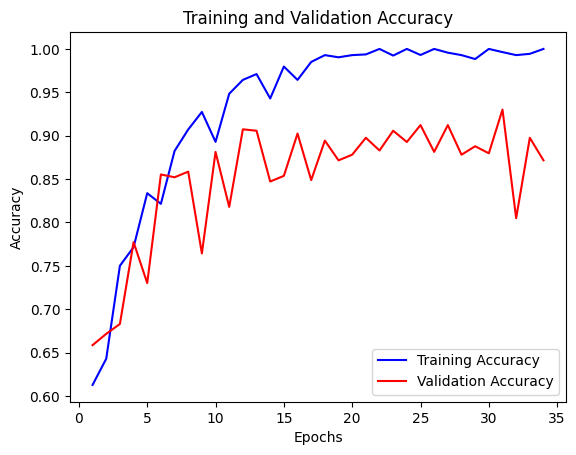

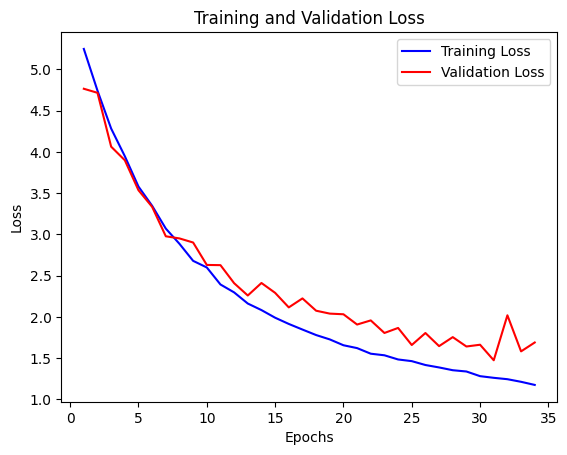

In [68]:
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step
Accuracy on test dataset: 0.5228

Classification Report:
               precision    recall  f1-score   support

    fracture       0.53      0.47      0.50       387
  nofracture       0.52      0.57      0.54       380

    accuracy                           0.52       767
   macro avg       0.52      0.52      0.52       767
weighted avg       0.52      0.52      0.52       767



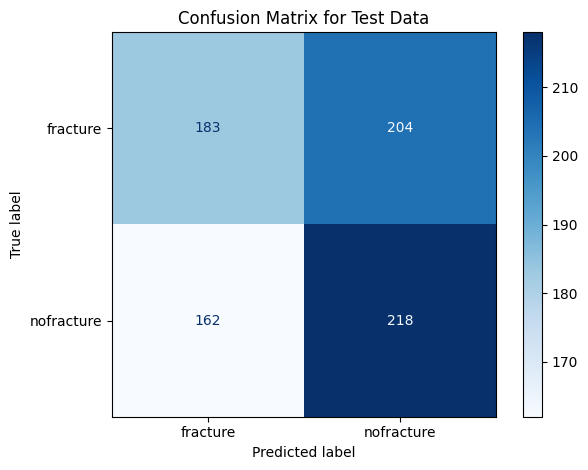

In [69]:
accuracy, class_report, cm = plot_confusion_matrix(model_VGG16_2, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step
AUC: 0.4511


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


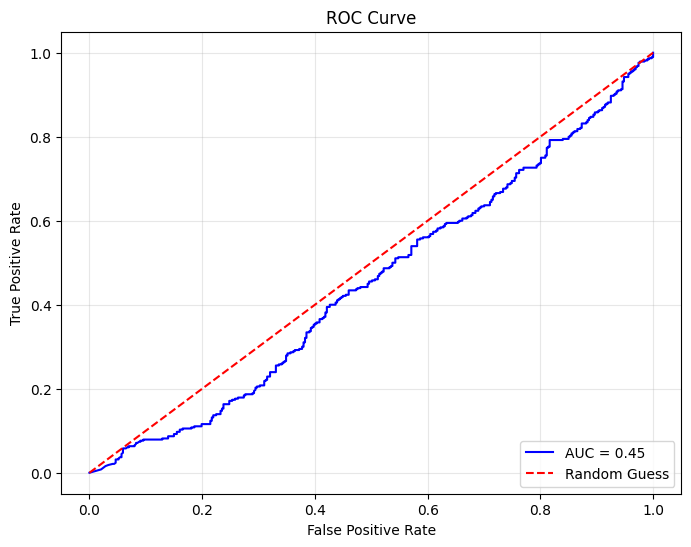

In [70]:
auc = plot_auc_curve(model_VGG16_2, test_ds)

------------------------------

**Model 2.1**

In [71]:
model_VGG16_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_VGG16_2.add(conv_base_VGG16)

# Add personalized layers
model_VGG16_2.add(layers.Flatten())  # Flatten extracted features
model_VGG16_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_VGG16_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_VGG16_2.add(layers.Dense(1, activation='sigmoid'))

model_VGG16_2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 19,402,241 (74.01 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [73]:
optimizer = Adam(learning_rate=1e-5)
model_VGG16_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_VGG16_2, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 248ms/step - accuracy: 0.7067 - loss: 5.5817 - val_accuracy: 0.8764 - val_loss: 5.0933 - learning_rate: 1.0000e-05
Epoch 2/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 213ms/step - accuracy: 0.8920 - loss: 5.0419

2024-12-04 12:48:51.341565: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.8985 - loss: 5.0285 - val_accuracy: 0.8602 - val_loss: 5.0631 - learning_rate: 1.0000e-05
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 243ms/step - accuracy: 0.9250 - loss: 4.8794 - val_accuracy: 0.9024 - val_loss: 4.7713 - learning_rate: 1.0000e-05
Epoch 4/100
 27/130 ━━━━━━━━━━━━━━━━━━━━ 22s 214ms/step - accuracy: 0.9468 - loss: 4.6295

2024-12-04 12:49:33.271321: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:49:33.271350: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9493 - loss: 4.6198 - val_accuracy: 0.8862 - val_loss: 4.7637 - learning_rate: 1.0000e-05
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 244ms/step - accuracy: 0.9799 - loss: 4.4901 - val_accuracy: 0.8959 - val_loss: 4.5252 - learning_rate: 1.0000e-05
Epoch 6/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 0.9898 - loss: 4.2969

2024-12-04 12:50:14.299900: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9860 - loss: 4.2826 - val_accuracy: 0.8911 - val_loss: 4.5322 - learning_rate: 1.0000e-05
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 244ms/step - accuracy: 0.9857 - loss: 4.2030 - val_accuracy: 0.8959 - val_loss: 4.2857 - learning_rate: 1.0000e-05
Epoch 8/100
 26/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 0.9944 - loss: 4.0141

2024-12-04 12:50:55.495725: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9944 - loss: 4.0051 - val_accuracy: 0.8780 - val_loss: 4.3113 - learning_rate: 1.0000e-05
Epoch 9/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9873 - loss: 3.9434 - val_accuracy: 0.8894 - val_loss: 4.1490 - learning_rate: 1.0000e-05
Epoch 10/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.9951 - loss: 3.7711

2024-12-04 12:51:36.890862: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9946 - loss: 3.7623 - val_accuracy: 0.9073 - val_loss: 4.0321 - learning_rate: 1.0000e-05
Epoch 11/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9900 - loss: 3.7041 - val_accuracy: 0.9057 - val_loss: 3.8206 - learning_rate: 1.0000e-05
Epoch 12/100
 27/130 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.9891 - loss: 3.5632

2024-12-04 12:52:18.325101: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9889 - loss: 3.5541 - val_accuracy: 0.9398 - val_loss: 3.6911 - learning_rate: 1.0000e-05
Epoch 13/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9964 - loss: 3.4802 - val_accuracy: 0.9285 - val_loss: 3.6032 - learning_rate: 1.0000e-05
Epoch 14/100
 23/130 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step - accuracy: 0.9890 - loss: 3.3494

2024-12-04 12:52:59.654071: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9889 - loss: 3.3415 - val_accuracy: 0.8683 - val_loss: 3.7610 - learning_rate: 1.0000e-05
Epoch 15/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9781 - loss: 3.3191 - val_accuracy: 0.8894 - val_loss: 3.5717 - learning_rate: 1.0000e-05
Epoch 16/100
 26/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 0.9962 - loss: 3.1570

2024-12-04 12:53:41.055805: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9918 - loss: 3.1547 - val_accuracy: 0.8699 - val_loss: 3.6224 - learning_rate: 1.0000e-05
Epoch 17/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9976 - loss: 3.0939 - val_accuracy: 0.9122 - val_loss: 3.3449 - learning_rate: 1.0000e-05
Epoch 18/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 2.9717

2024-12-04 12:54:22.467340: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 1.0000 - loss: 2.9647 - val_accuracy: 0.8959 - val_loss: 3.3844 - learning_rate: 1.0000e-05
Epoch 19/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9979 - loss: 2.9186 - val_accuracy: 0.8911 - val_loss: 3.2520 - learning_rate: 1.0000e-05
Epoch 20/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 0.9994 - loss: 2.8013

2024-12-04 12:55:03.802877: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9984 - loss: 2.7967 - val_accuracy: 0.8602 - val_loss: 3.3930 - learning_rate: 1.0000e-05
Epoch 21/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9982 - loss: 2.7517 - val_accuracy: 0.9122 - val_loss: 3.0190 - learning_rate: 1.0000e-05
Epoch 22/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 2.6441

2024-12-04 12:55:45.196424: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 1.0000 - loss: 2.6359 - val_accuracy: 0.9073 - val_loss: 3.0191 - learning_rate: 1.0000e-05
Epoch 23/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9986 - loss: 2.5892 - val_accuracy: 0.8959 - val_loss: 2.9173 - learning_rate: 1.0000e-05
Epoch 24/100
 26/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 2.4846

2024-12-04 12:56:26.588144: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:56:26.588171: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 1.0000 - loss: 2.4797 - val_accuracy: 0.9154 - val_loss: 2.8466 - learning_rate: 1.0000e-05
Epoch 25/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9992 - loss: 2.4366 - val_accuracy: 0.8976 - val_loss: 2.8038 - learning_rate: 1.0000e-05
Epoch 26/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9985 - loss: 2.3352 - val_accuracy: 0.8309 - val_loss: 3.1606 - learning_rate: 1.0000e-05
Epoch 27/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9975 - loss: 2.3002 - val_accuracy: 0.9089 - val_loss: 2.5563 - learning_rate: 1.0000e-05
Epoch 28/100
 25/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 2.2006

2024-12-04 12:57:49.323538: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9985 - loss: 2.2002 - val_accuracy: 0.9301 - val_loss: 2.4634 - learning_rate: 1.0000e-05
Epoch 29/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9930 - loss: 2.1717 - val_accuracy: 0.8455 - val_loss: 2.4636 - learning_rate: 1.0000e-05
Epoch 30/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 0.9589 - loss: 2.1722

2024-12-04 12:58:30.723848: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:58:30.723883: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9728 - loss: 2.1446 - val_accuracy: 0.8667 - val_loss: 2.5118 - learning_rate: 1.0000e-05
Epoch 31/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9912 - loss: 2.0647 - val_accuracy: 0.8911 - val_loss: 2.4206 - learning_rate: 1.0000e-05
Epoch 32/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.9950 - loss: 1.9718

2024-12-04 12:59:12.150146: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9961 - loss: 1.9667 - val_accuracy: 0.8992 - val_loss: 2.3611 - learning_rate: 1.0000e-05
Epoch 33/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9954 - loss: 1.9450 - val_accuracy: 0.9089 - val_loss: 2.2695 - learning_rate: 1.0000e-05
Epoch 34/100
 26/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 1.8679

2024-12-04 12:59:53.581390: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 12:59:53.581418: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 1.0000 - loss: 1.8623 - val_accuracy: 0.9057 - val_loss: 2.2570 - learning_rate: 1.0000e-05
Epoch 35/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9998 - loss: 1.8313 - val_accuracy: 0.9024 - val_loss: 2.2037 - learning_rate: 1.0000e-05
Epoch 36/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 1.7650

2024-12-04 13:00:35.023769: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 13:00:35.023802: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 1.0000 - loss: 1.7613 - val_accuracy: 0.9057 - val_loss: 2.2003 - learning_rate: 1.0000e-05
Epoch 37/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9993 - loss: 1.7335 - val_accuracy: 0.9073 - val_loss: 2.0950 - learning_rate: 1.0000e-05
Epoch 38/100
 25/130 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 1.0000 - loss: 1.6676

2024-12-04 13:01:16.430483: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 1.0000 - loss: 1.6641 - val_accuracy: 0.9041 - val_loss: 2.1130 - learning_rate: 1.0000e-05
Epoch 39/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9992 - loss: 1.6363 - val_accuracy: 0.8602 - val_loss: 2.2606 - learning_rate: 1.0000e-05
Epoch 40/100
 26/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 1.5761

2024-12-04 13:01:57.803581: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9985 - loss: 1.5740 - val_accuracy: 0.8992 - val_loss: 2.0058 - learning_rate: 1.0000e-05
Epoch 41/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9931 - loss: 1.5564 - val_accuracy: 0.8455 - val_loss: 2.2486 - learning_rate: 1.0000e-05
Epoch 42/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.9837 - loss: 1.5259

2024-12-04 13:02:39.263254: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 13:02:39.263287: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9908 - loss: 1.5153 - val_accuracy: 0.8699 - val_loss: 1.9655 - learning_rate: 1.0000e-05
Epoch 43/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9969 - loss: 1.4687 - val_accuracy: 0.9203 - val_loss: 1.8065 - learning_rate: 1.0000e-05
Epoch 44/100
 24/130 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 1.0000 - loss: 1.4048

2024-12-04 13:03:20.744871: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 1.0000 - loss: 1.4022 - val_accuracy: 0.9220 - val_loss: 1.7540 - learning_rate: 1.0000e-05
Epoch 45/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9997 - loss: 1.3775 - val_accuracy: 0.9073 - val_loss: 1.7908 - learning_rate: 1.0000e-05
Epoch 46/100
 26/130 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - accuracy: 1.0000 - loss: 1.3242

2024-12-04 13:04:02.180783: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 13:04:02.180812: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 1.0000 - loss: 1.3208 - val_accuracy: 0.9138 - val_loss: 1.7583 - learning_rate: 1.0000e-05
Epoch 47/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 245ms/step - accuracy: 0.9964 - loss: 1.3053 - val_accuracy: 0.8016 - val_loss: 2.3676 - learning_rate: 1.0000e-05


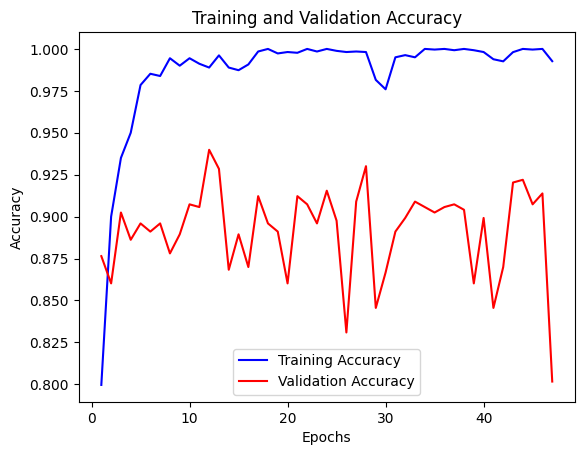

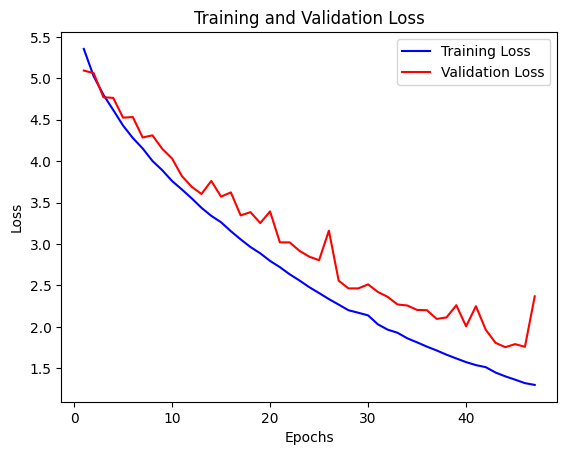

In [75]:
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step
Accuracy on test dataset: 0.4746

Classification Report:
               precision    recall  f1-score   support

    fracture       0.48      0.41      0.44       387
  nofracture       0.47      0.54      0.51       380

    accuracy                           0.47       767
   macro avg       0.47      0.48      0.47       767
weighted avg       0.47      0.47      0.47       767



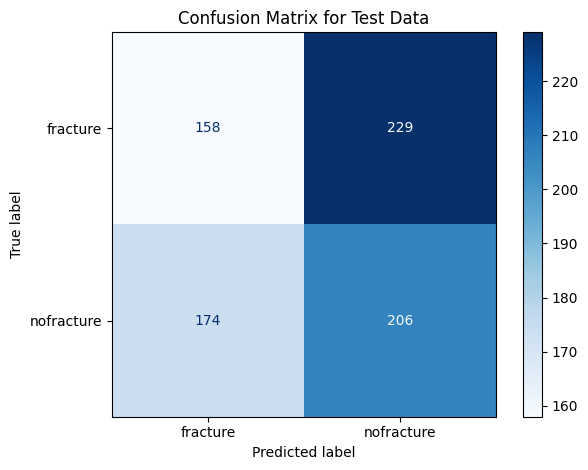

In [76]:
accuracy, class_report, cm = plot_confusion_matrix(model_VGG16_2, test_ds, class_names = class_names)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
AUC: 0.4945


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


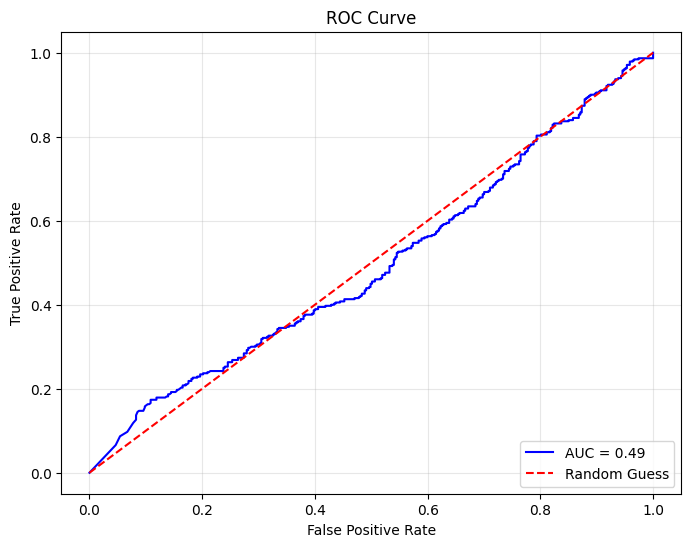

In [77]:
auc = plot_auc_curve(model_VGG16_2, test_ds)

### *Transfer learning*

**Model 3**

In [ ]:
'''
#Unfreezing the lats 8 layers
for layer in conv_base_VGG16.layers[-8:]:
    layer.trainable = True
'''

In [79]:
#Extract features
train_features, train_labels = extract_features(conv_base_VGG16, train_ds)
val_features, val_labels = extract_features(conv_base_VGG16, val_ds)
test_features, test_labels = extract_features(conv_base_VGG16, test_ds)

In [80]:
#Flatering features to vonverto to a 2D array for machine learning algorithms
train_features = train_features.reshape(train_features.shape[0], -1) #[0] number of samples in the dataset and -1 indicated to Numpy to 
#automatically calculate the size of the second dimension to preserve the total number of elements.
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

In [81]:
#Training the Machine Learning Model

#Random forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(train_features, train_labels)

/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

Accuracy en validación: 0.877444589308996
              precision    recall  f1-score   support

         0.0       1.00      0.76      0.86       387
         1.0       0.80      1.00      0.89       380

    accuracy                           0.88       767
   macro avg       0.90      0.88      0.88       767
weighted avg       0.90      0.88      0.88       767



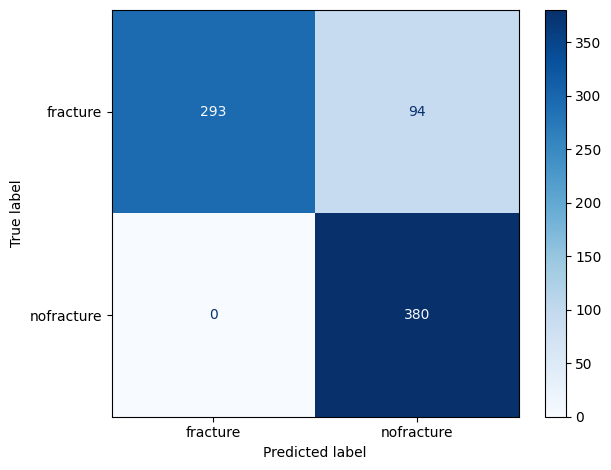

In [84]:
#Evaluating the model
test_predictions = random_forest.predict(test_features)
print("Accuracy en validación:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

cm = confusion_matrix(test_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

-----------------

### **Pretrained network ResNet-50**

In [85]:
#Load ResNet
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Freezing the layers
resnet_base.trainable = False

resnet_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_12[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

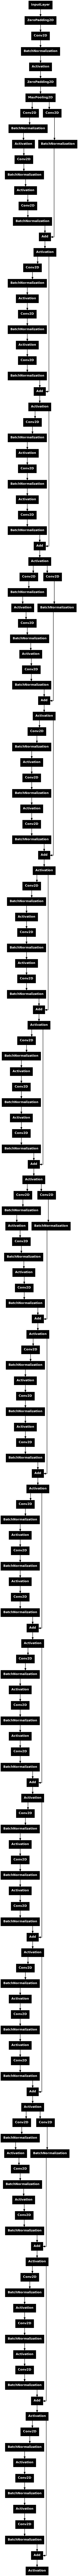

In [8]:
tf.keras.utils.plot_model(resnet_base)

### *Loading and preprocesing images*

In [86]:
train_ds = create_image_dataset(train_dir, subset = None, validation_split = None, image_size=(224, 224), batch_size=32)
val_ds = create_image_dataset(val_dir, subset = None, validation_split = None, image_size=(224, 224), batch_size=32)
test_ds = create_image_dataset(test_dir, subset = None, validation_split = None, image_size=(224, 224), batch_size=32)
class_names = train_ds.class_names

Found 3140 files belonging to 2 classes.
Found 615 files belonging to 2 classes.
Found 767 files belonging to 2 classes.


In [87]:
train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255 
)

'''train_ds = apply_preprocessing(
    train_ds,
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    output_size=(224, 224)
)'''

val_ds = apply_preprocessing(
    val_ds,
    rescale=1./255 
)

test_ds = apply_preprocessing(
    test_ds,
    rescale=1./255)

### *Fine-tunning*

**Model 1**

In [88]:
model_resnet_1 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_resnet_1.add(resnet_base)

# Add personalized layers
model_resnet_1.add(layers.Flatten())  # Flatten extracted features
model_resnet_1.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_resnet_1.add(layers.Dropout(0.3))  #To avoid over-fitting
model_resnet_1.add(layers.Dense(1, activation='sigmoid'))

model_resnet_1.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,278,337 (187.98 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

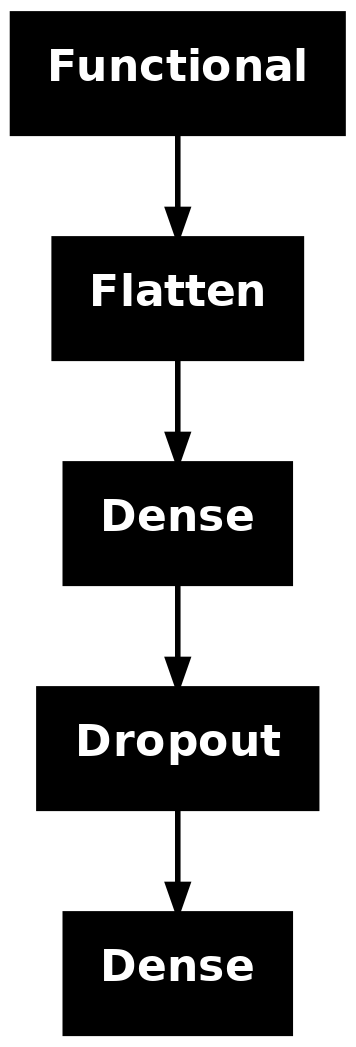

In [10]:
tf.keras.utils.plot_model(model_resnet_1)

In [89]:
optimizer = Adam(learning_rate=1e-5)
model_resnet_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [90]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 
history = train_model(model_resnet_1, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100


 99/130 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.5411 - loss: 5.4488

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 130ms/step - accuracy: 0.5437 - loss: 5.3460 - val_accuracy: 0.4959 - val_loss: 4.2537 - learning_rate: 1.0000e-05
Epoch 2/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5658 - loss: 3.9170

2024-12-04 13:49:33.005642: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 13:49:33.005677: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.5682 - loss: 3.8470 - val_accuracy: 0.4959 - val_loss: 3.1670 - learning_rate: 1.0000e-05
Epoch 3/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5776 - loss: 2.8954

2024-12-04 13:49:42.518387: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 13:49:42.518412: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.5808 - loss: 2.8477 - val_accuracy: 0.4959 - val_loss: 2.3529 - learning_rate: 1.0000e-05
Epoch 4/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5596 - loss: 2.1977

2024-12-04 13:49:52.323689: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.5667 - loss: 2.1634 - val_accuracy: 0.4992 - val_loss: 1.8348 - learning_rate: 1.0000e-05
Epoch 5/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.5976 - loss: 1.7102

2024-12-04 13:50:01.929202: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.5983 - loss: 1.6879 - val_accuracy: 0.4959 - val_loss: 1.5421 - learning_rate: 1.0000e-05
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.5834 - loss: 1.3790 - val_accuracy: 0.4976 - val_loss: 1.2816 - learning_rate: 1.0000e-05
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.5882 - loss: 1.1672 - val_accuracy: 0.4976 - val_loss: 1.1625 - learning_rate: 1.0000e-05
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.5965 - loss: 1.0271 - val_accuracy: 0.5008 - val_loss: 1.0035 - learning_rate: 1.0000e-05
Epoch 9/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5882 - loss: 0.9462

2024-12-04 13:50:40.926906: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 13:50:40.926930: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.5918 - loss: 0.9412 - val_accuracy: 0.5154 - val_loss: 0.9216 - learning_rate: 1.0000e-05
Epoch 10/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6067 - loss: 0.8866

2024-12-04 13:50:50.901433: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.6068 - loss: 0.8837 - val_accuracy: 0.4992 - val_loss: 0.9128 - learning_rate: 1.0000e-05
Epoch 11/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.6061 - loss: 0.8423 - val_accuracy: 0.5008 - val_loss: 0.8629 - learning_rate: 1.0000e-05
Epoch 12/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5907 - loss: 0.8294 - val_accuracy: 0.4992 - val_loss: 0.8945 - learning_rate: 1.0000e-05
Epoch 13/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.5866 - loss: 0.8155

2024-12-04 13:51:20.538208: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9014993472667404461
2024-12-04 13:51:20.538233: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11759106104943731589


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.5898 - loss: 0.8146 - val_accuracy: 0.4992 - val_loss: 0.8750 - learning_rate: 1.0000e-05
Epoch 14/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5946 - loss: 0.8045 - val_accuracy: 0.4992 - val_loss: 0.8687 - learning_rate: 1.0000e-05


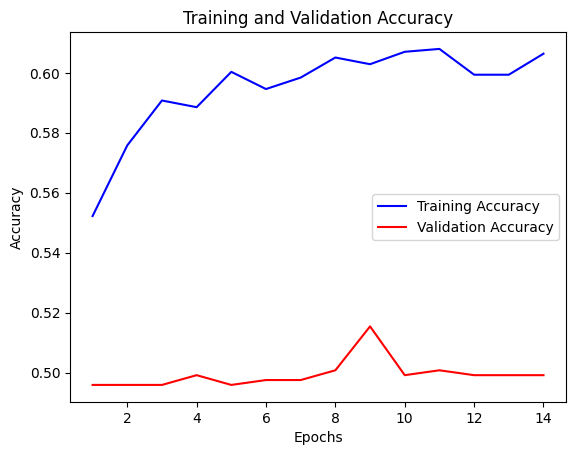

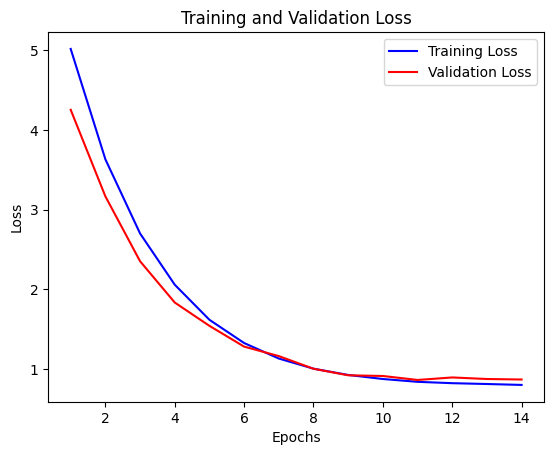

In [91]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
plot_training_history(history)

23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

2024-12-04 13:59:45.516131: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[31,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-04 13:59:45.927912: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[31,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActi

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step
Accuracy on test dataset: 0.5033

Classification Report:
               precision    recall  f1-score   support

    fracture       0.80      0.02      0.04       387
  nofracture       0.50      0.99      0.66       380

    accuracy                           0.50       767
   macro avg       0.65      0.51      0.35       767
weighted avg       0.65      0.50      0.35       767



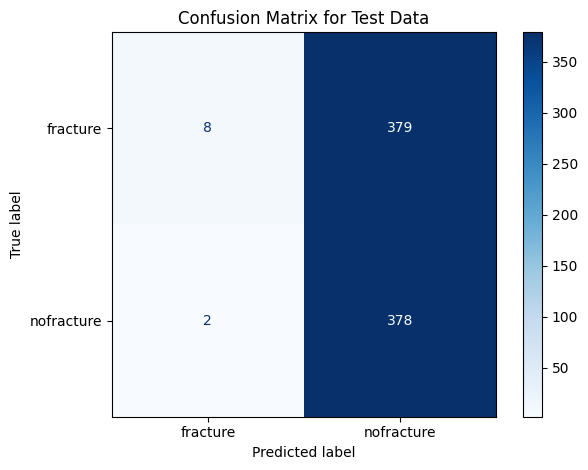

In [92]:
accuracy, class_report, cm = plot_confusion_matrix(model_resnet_1, test_ds, class_names = class_names)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
AUC: 0.4850


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


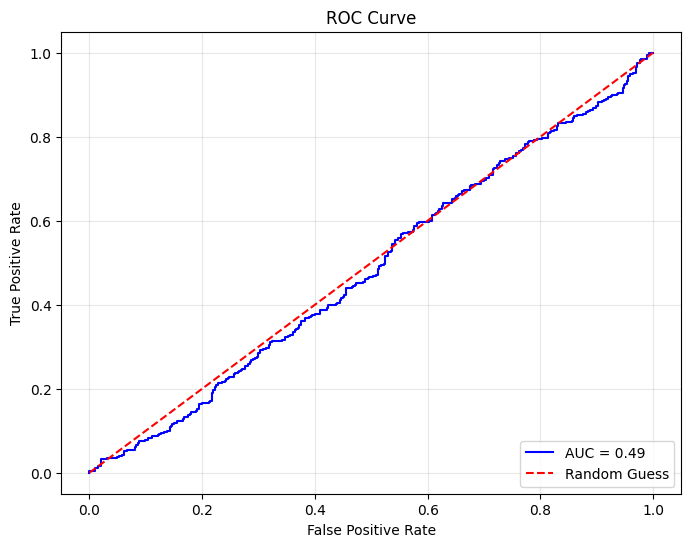

In [93]:
auc = plot_auc_curve(model_resnet_1, test_ds)

**Model 2**

In [94]:
model_resnet_2 = models.Sequential()

# Add pretrained networkAñadir la base preentrenada
model_resnet_2.add(resnet_base)

# Add personalized layers
model_resnet_2.add(layers.GlobalAveragePooling2D())
model_resnet_2.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Full-connected layer
model_resnet_2.add(layers.Dropout(0.3))  #To avoid over-fitting
model_resnet_2.add(layers.Dense(1, activation='sigmoid'))

model_resnet_2.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

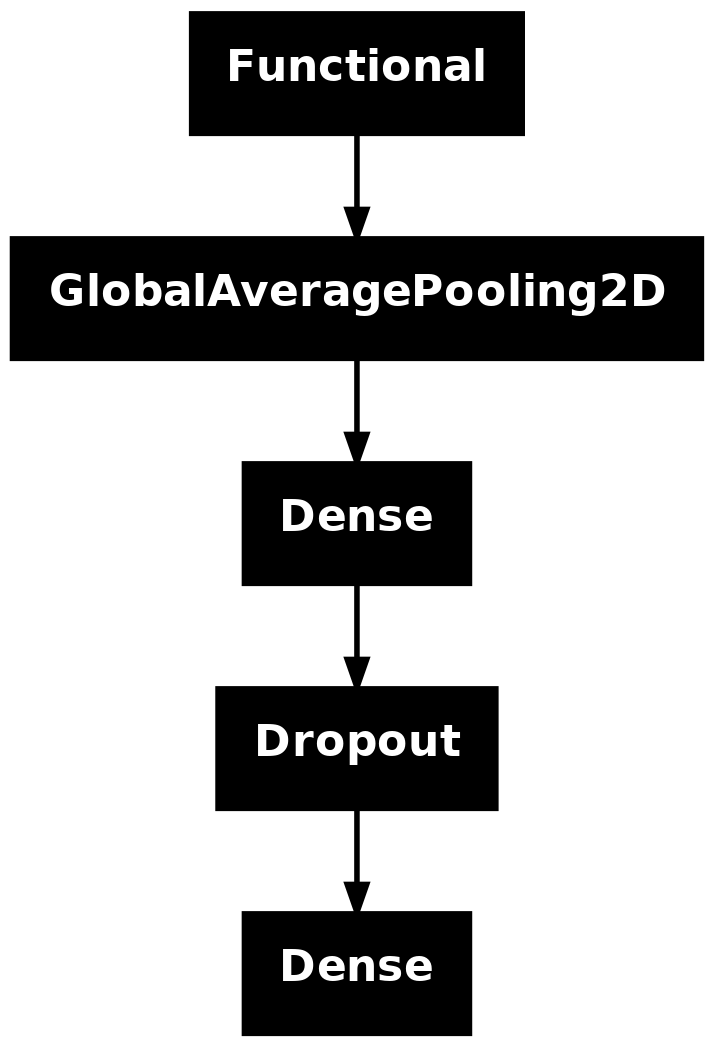

In [38]:
tf.keras.utils.plot_model(model_resnet_2)

In [95]:
optimizer = Adam(learning_rate=1e-5)
model_resnet_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [96]:
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
#Callback to reduce learning rate when val_loss in 0.5 doesn't improve in 3 epochs. Minimum learning rate = 1e-6
reduce_lr = create_reduce_lr_callback(patience = 5)

#Callback for stop running model when val_loss doesn't improve in 10 epochs
early_stopping = create_early_stopping_callback(patience = 3)

#Train the model 

history = train_model(model_resnet_2, train_ds, steps_per_epoch = 130, validation_data = val_ds, callbacks=[reduce_lr, early_stopping])

Epoch 1/100
 99/130 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.5741 - loss: 5.2068

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.5711 - loss: 5.1916 - val_accuracy: 0.4959 - val_loss: 5.0207 - learning_rate: 1.0000e-05
Epoch 2/100
 98/130 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5542 - loss: 4.9583

2024-12-04 14:00:45.494123: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.5548 - loss: 4.9448 - val_accuracy: 0.4959 - val_loss: 4.7890 - learning_rate: 1.0000e-05
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.5466 - loss: 4.7233 - val_accuracy: 0.4959 - val_loss: 4.5686 - learning_rate: 1.0000e-05
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.5645 - loss: 4.4939 - val_accuracy: 0.4959 - val_loss: 4.3645 - learning_rate: 1.0000e-05
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.5620 - loss: 4.2860 - val_accuracy: 0.4959 - val_loss: 4.1710 - learning_rate: 1.0000e-05
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.5611 - loss: 4.0959 - val_accuracy: 0.4959 - val_loss: 3.9815 - learning_rate: 1.0000e-05
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.5553 - loss: 3.9146 - val_accuracy: 0.4959 - val_loss: 3.7977 - learning_rate: 1.0000e-05
Epoch 8/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy

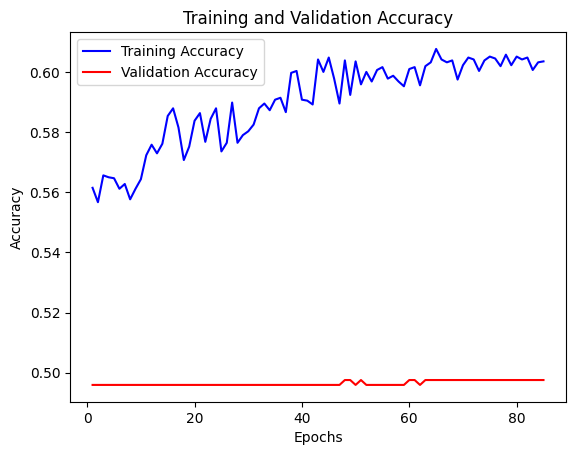

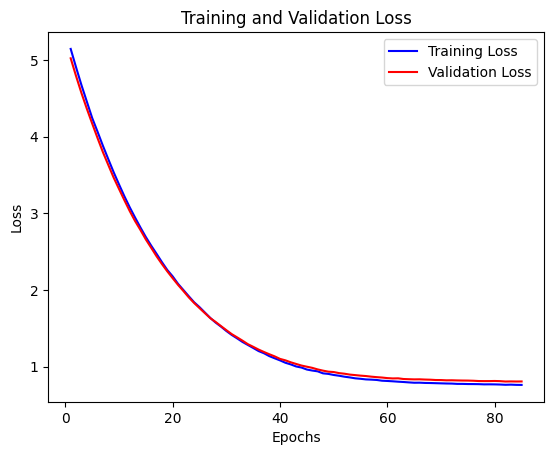

In [97]:
#Obtaining train accuracy (train_acc), validation accuracy (val_acc), train loss (train_loss) and validation loss (val_loss) from model trianing (history)
plot_training_history(history)

24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step
Accuracy on test dataset: 0.4954

Classification Report:
               precision    recall  f1-score   support

    fracture       0.00      0.00      0.00       387
  nofracture       0.50      1.00      0.66       380

    accuracy                           0.50       767
   macro avg       0.25      0.50      0.33       767
weighted avg       0.25      0.50      0.33       767



/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

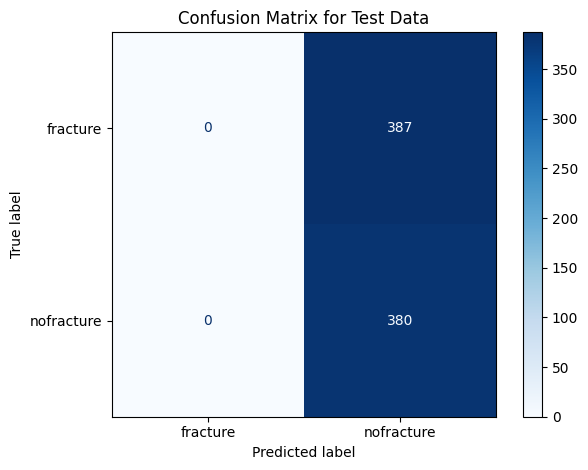

In [98]:
accuracy, class_report, cm = plot_confusion_matrix(model_resnet_2, test_ds, class_names = class_names)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step
AUC: 0.4915


/home/dtbird/Documentos/OsteoAI/scr/metrics_CNN.py:150: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Reference line for random classifier


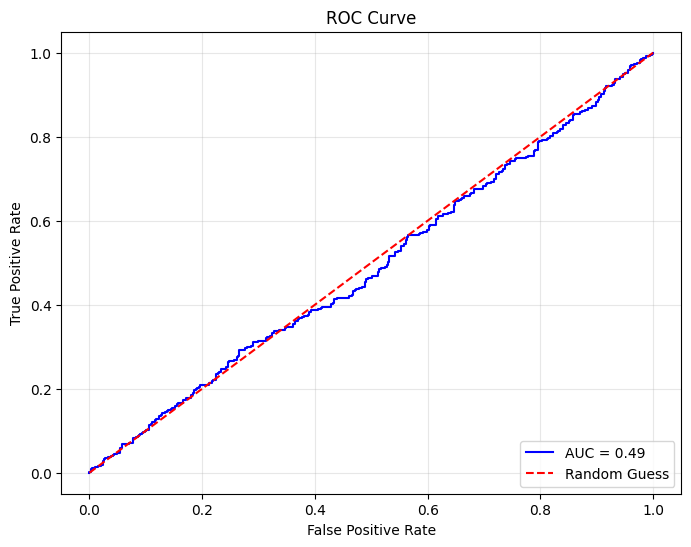

In [99]:
auc = plot_auc_curve(model_resnet_2, test_ds)

--------------------------

### *Transfer learning*

**Model 3**

In [105]:
#Unfreezing the lats 8 layers
for layer in resnet_base.layers[-8:]:
    layer.trainable = True

In [106]:
#Extract features
train_features, train_labels = extract_features(resnet_base, train_ds)
val_features, val_labels = extract_features(resnet_base, val_ds)
test_features, test_labels = extract_features(resnet_base, test_ds)

In [107]:
#Flatering features to vonverto to a 2D array for machine learning algorithms
train_features = train_features.reshape(train_features.shape[0], -1) #[0] number of samples in the dataset and -1 indicated to Numpy to 
#automatically calculate the size of the second dimension to preserve the total number of elements.
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

In [108]:
#Training the Machine Learning Model

#Random forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(train_features, train_labels)

/home/dtbird/Documentos/OsteoAI/venv/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

Accuracy en validación: 0.6923076923076923
              precision    recall  f1-score   support

         0.0       1.00      0.39      0.56       387
         1.0       0.62      1.00      0.76       380

    accuracy                           0.69       767
   macro avg       0.81      0.70      0.66       767
weighted avg       0.81      0.69      0.66       767



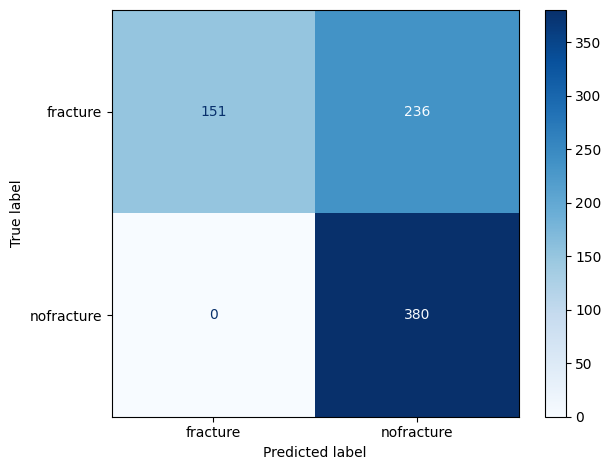

In [109]:
#Evaluating the model
test_predictions = random_forest.predict(test_features)
print("Accuracy en validación:", accuracy_score(test_labels, test_predictions))
print(classification_report(test_labels, test_predictions))

cm = confusion_matrix(test_labels, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()